# PSF Photometry


**Use case:** PSF photometry, creating a PSF, derive Color-Magnitude Diagram.<br>
**Data:** NIRCam simulated images of the Large Magellanic Cloud (LMC) Astrometric Calibration Field obtained using [MIRAGE](https://jwst-docs.stsci.edu/jwst-other-tools/mirage-jwst-data-simulator) and run through the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/). The simulations are obtained using a 4-point subpixel dither for three pairs of wide filters: F070W, F115W, and F200W for the SW channel, and F277W, F356W, and F444W for the LW channel. We simulated only 1 NIRCam SW detector (i.e., "NRCB1"). For this example, we use Level-2 images (.cal, calibrated but not rectified) for two SW filters (F115W and F200W) and derive the photometry in each of them. The images for the other filters are also available and can be used to test the notebook and/or different filter combinations.<br>
**Tools:**  photutils.<br>
**Cross-intrument:** NIRSpec, NIRISS, MIRI.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>


PSF Photometry can be obtained using:

* single model obtained from WebbPSF
* grid of PSF models from WebbPSF
* single effective PSF (ePSF)

### Work in Progress:

* create a grid of ePSF and perform reduction using the ePSF grid
* use the ePSF grid to perturbate the WebbPSF model

The notebook shows:

* how to obtain the PSF model from WebbPSF (or build an ePSF)
* how to perform PSF photometry on the image
* how to cross-match the catalogs of the different images
* how to derive and apply photometric zeropoint

Final plots show:

* Instrumental Color-Magnitude Diagrams for the 4 images
* Instrumental Color-Magnitude Diagrams and errors
* Magnitudes Zeropoints 
* Calibrated Color-Magnitude Diagram (compared with Input Color-Magnitude Diagram)
* Comparison between input and output photometry

**Note on pysynphot**: Data files for pysynphot are distributed separately by the Calibration Reference Data System (CRDS). They are expected to follow a certain directory structure under the root directory, identified by the PYSYN_CDBS environment variable that must be set prior to using this package. In the example below, the root directory is arbitrarily named /my/local/dir/trds/. \
export PYSYN_CDBS=/my/local/dir/trds/ \
See documentation [here](https://pysynphot.readthedocs.io/en/latest/#installation-and-setup) for the configuration and download of the data files.

## Imports

In [1]:
import glob as glob
import os
import tarfile
import time
import warnings
from urllib import request

import numpy as np
import pandas as pd
import webbpsf
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io import fits
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import QTable, Table
from astropy.utils.exceptions import AstropyUserWarning
from astropy.visualization import simple_norm
from jwst.datamodels import ImageModel
from photutils.aperture import (CircularAnnulus, CircularAperture,
                                aperture_photometry)
from photutils.background import MADStdBackgroundRMS, MMMBackground
from photutils.detection import DAOStarFinder
from photutils.psf import (EPSFBuilder, GriddedPSFModel, IterativePSFPhotometry,
                           SourceGrouper, extract_stars)

## Import Plotting Functions

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 14

font1 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '12'}
font2 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '20'}

## Download WebbPSF and Synphot Data

In [3]:
# Set environmental variables
os.environ["WEBBPSF_PATH"] = "./webbpsf-data/webbpsf-data"
os.environ["PYSYN_CDBS"] = "./grp/redcat/trds/"

# WEBBPSF Data
boxlink = 'https://stsci.box.com/shared/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz'
boxfile = './webbpsf-data/webbpsf-data-LATEST.tar.gz'
synphot_url = 'http://ssb.stsci.edu/trds/tarfiles/synphot5.tar.gz'
synphot_file = './synphot5.tar.gz'

webbpsf_folder = './webbpsf-data'
synphot_folder = './grp'

# Gather webbpsf files
if not os.path.exists(webbpsf_folder):
    os.makedirs(webbpsf_folder)
    request.urlretrieve(boxlink, boxfile)
    gzf = tarfile.open(boxfile)
    gzf.extractall(webbpsf_folder, filter='data')

# Gather synphot files
if not os.path.exists(synphot_folder):
    os.makedirs(synphot_folder)
    request.urlretrieve(synphot_url, synphot_file)
    gzf = tarfile.open(synphot_file)
    gzf.extractall('./', filter='data')

##  Load the images and create some useful dictionaries

We load all the images and we create a dictionary that contains all of them, divided by detectors and filters. This is useful to check which detectors and filters are available and to decide if we want to perform the photometry on all of them or only on a subset (for example, only on the SW filters). 

We also create a dictionary with some useful parameters for the analysis. The dictionary contains the photometric zeropoints (from [MIRAGE](https://jwst-docs.stsci.edu/jwst-other-tools/mirage-data-simulator) configuration files) and the NIRCam point spread function (PSF) FWHM, from the [NIRCam Point Spread Function](https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions) JDox page. The FWHM are calculated from the analysis of the expected NIRCam PSFs simulated with [WebbPSF](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/psf-simulation-tool). 

**Note**: this dictionary will be updated once the values for zeropoints and FWHM will be available for each detectors after commissioning. 

Hence, we have two dictionaries:

* dictionary for the single Level-2 calibrated images
* dictionary with some other useful parameters


In [4]:
dict_images = {'NRCA1': {}, 'NRCA2': {}, 'NRCA3': {}, 'NRCA4': {}, 'NRCA5': {},
               'NRCB1': {}, 'NRCB2': {}, 'NRCB3': {}, 'NRCB4': {}, 'NRCB5': {}}

dict_filter_short = {}
dict_filter_long = {}

ff_short = []
det_short = []
det_long = []
ff_long = []
detlist_short = []
detlist_long = []
filtlist_short = []
filtlist_long = []

if not glob.glob('./*cal*fits'):
    print("Downloading images")

    boxlink_images_lev2 = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/stellar_photometry/images_level2.tar.gz'
    boxfile_images_lev2 = './images_level2.tar.gz'
    request.urlretrieve(boxlink_images_lev2, boxfile_images_lev2)

    tar = tarfile.open(boxfile_images_lev2, 'r')
    tar.extractall(filter='data')

    images_dir = './'
    images = sorted(glob.glob(os.path.join(images_dir, "*cal.fits")))

else:
    images_dir = './'
    images = sorted(glob.glob(os.path.join(images_dir, "*cal.fits")))

for image in images:
    im = fits.open(image)
    f = im[0].header['FILTER']
    d = im[0].header['DETECTOR']

    if d == 'NRCBLONG':
        d = 'NRCB5'
    elif d == 'NRCALONG':
        d = 'NRCA5'
    else:
        d = d

    wv = float(f[1:3])

    if wv > 24:         
        ff_long.append(f)
        det_long.append(d)

    else:
        ff_short.append(f)
        det_short.append(d)   

    detlist_short = sorted(list(dict.fromkeys(det_short)))
    detlist_long = sorted(list(dict.fromkeys(det_long)))

    unique_list_filters_short = []
    unique_list_filters_long = []

    for x in ff_short:
        if x not in unique_list_filters_short:
            dict_filter_short.setdefault(x, {})

    for x in ff_long:
        if x not in unique_list_filters_long:
            dict_filter_long.setdefault(x, {})   

    for d_s in detlist_short:
        dict_images[d_s] = dict_filter_short

    for d_l in detlist_long:
        dict_images[d_l] = dict_filter_long

    filtlist_short = sorted(list(dict.fromkeys(dict_filter_short)))
    filtlist_long = sorted(list(dict.fromkeys(dict_filter_long)))

    if len(dict_images[d][f]) == 0:
        dict_images[d][f] = {'images': [image]}
    else:
        dict_images[d][f]['images'].append(image)

print("Available Detectors for SW channel:", detlist_short)
print("Available Detectors for LW channel:", detlist_long)
print("Available SW Filters:", filtlist_short)
print("Available LW Filters:", filtlist_long)

Available Detectors for SW channel: ['NRCB1']
Available Detectors for LW channel: ['NRCB5']
Available SW Filters: ['F070W', 'F115W', 'F200W']
Available LW Filters: ['F277W', 'F356W', 'F444W']


In [5]:
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2', 'F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.987, 1.103, 1.298, 1.553, 1.628, 1.770, 1.801, 1.494, 1.990, 2.060, 2.141, 2.304, 2.341, 1.340,
            1.444, 1.585, 1.547, 1.711, 1.760, 1.830, 1.901, 2.165, 2.179, 2.300, 2.302, 2.459, 2.507, 2.535, 2.574]

zp_modA = [25.7977, 25.9686, 25.8419, 24.8878, 27.0048, 25.6536, 24.6957, 22.3073, 24.8258, 22.1775, 25.3677, 24.3296,
           22.1036, 22.7850, 23.5964, 24.8239, 23.6452, 25.3648, 20.8604, 23.5873, 24.3778, 23.4778, 20.5588,
           23.2749, 22.3584, 23.9731, 21.9502, 20.0428, 19.8869, 21.9002]

zp_modB = [25.7568, 25.9771, 25.8041, 24.8738, 26.9821, 25.6279, 24.6767, 22.2903, 24.8042, 22.1499, 25.3391, 24.2909,
           22.0574, 22.7596, 23.5011, 24.6792, 23.5769, 25.3455, 20.8631, 23.4885, 24.3883, 23.4555, 20.7007,
           23.2763, 22.4677, 24.1562, 22.0422, 20.1430, 20.0173, 22.4086]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i], 'VegaMAG zp modA': zp_modA[i],
                           'VegaMAG zp modB': zp_modB[i]} for i in range(len(filters))}

## Select the detectors and/or filters for the analysis

If we are interested only in some filters (and/or some detectors) in the analysis, as in this example, we can select the Level-2 calibrated images from the dictionary for those filters (detectors) and analyze only those images.

In this particular example, we analyze images for filters **F115W** and **F200W** for the detector **NRCB1**.

In [6]:
dets_short = ['NRCB1']  # detector of interest in this example
filts_short = ['F115W', 'F200W']  # filters of interest in this example

## Display the images

Check that our images do not present artifacts and can be used in the analysis.

2024-11-12 19:36:39,296 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,297 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,315 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,322 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,358 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,482 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,491 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,492 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,582 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,592 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,593 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,814 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,815 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,816 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,900 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,901 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,910 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,912 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,917 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:39,999 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:40,008 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:40,011 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


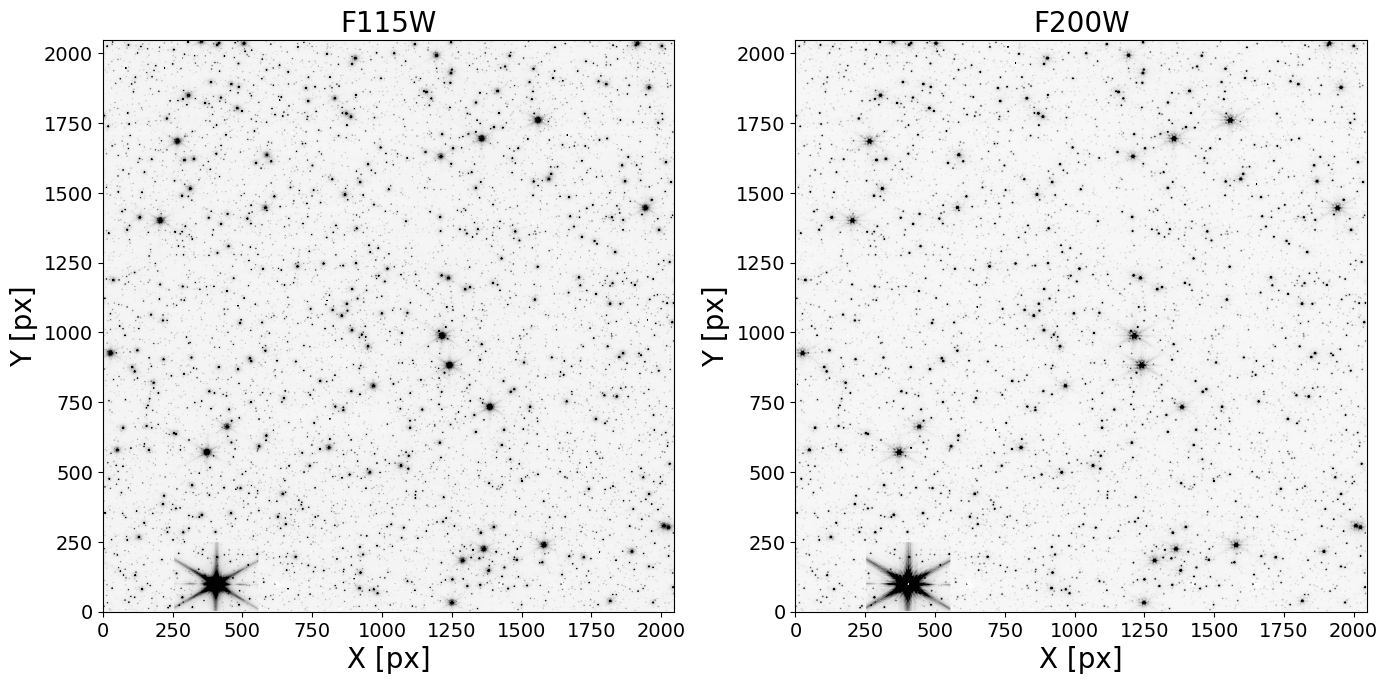

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 14))

for det in dets_short:
    for i, filt in enumerate(filts_short):
        image = fits.open(dict_images[det][filt]['images'][0])
        data_sb = image[1].data
        norm = simple_norm(data_sb, 'sqrt', percent=99.)
        ax[i].imshow(data_sb, norm=norm, cmap='Greys')
        ax[i].set_xlabel("X [px]", fontdict=font2)
        ax[i].set_ylabel("Y [px]", fontdict=font2)
        ax[i].set_title(filt, fontdict=font2)

plt.tight_layout()

## Create the PSF models

## I. Create the PSF model using WebbPSF

We create a dictionary that will contain the PSFs created using WebbPSF for the detectors and filters selected above.

In [8]:
dict_psfs_webbpsf = {}

for det in dets_short:
    dict_psfs_webbpsf.setdefault(det, {})
    for j, filt in enumerate(filts_short):
        dict_psfs_webbpsf[det].setdefault(filt, {})

        dict_psfs_webbpsf[det][filt]['psf model grid'] = None
        dict_psfs_webbpsf[det][filt]['psf model single'] = None

The function below creates a single PSF or a grid of PSFs and allows one to save the PSF as a fits file. The model PSFs are stored by default in the psf dictionary. For the grid of PSFs, users can select the number of PSFs to be created. The PSF can be created detector sampled or oversampled (the oversampling factor can be changed inside the function).

**Note**: The default source spectrum is, if `pysynphot` is installed, a G2V star spectrum from Castelli & Kurucz (2004). Without `pysynphot`, the default is a simple flat spectrum such that the same number of photons are detected at each wavelength.

In [9]:
def create_psf_model(det='NRCB1', fov=11, create_grid=False, num=9, save_psf=False, detsampled=False):
    nrc = webbpsf.NIRCam()
    nrc.detector = det 
    nrc.filter = filt

    src = webbpsf.specFromSpectralType('G5V', catalog='phoenix')
    if detsampled:
        print("Creating a detector sampled PSF")
        fov = 21
    else:
        print("Creating an oversampled PSF")
        fov = fov

    print(f"Using a {fov} px fov")

    if create_grid:
        print("")
        print(f"Creating a grid of PSF for filter {filt} and detector {det}")
        print("")

        outname = f'nircam_{det}_{filt}_fovp{fov}_samp4_npsf{num}.fits'
        if os.path.exists(outname):
            grid_psf = GriddedPSFModel.read(outname)
        else:
            grid_psf = nrc.psf_grid(num_psfs=num, oversample=4, source=src, all_detectors=False,
                                    fov_pixels=fov, use_detsampled_psf=detsampled,
                                    save=save_psf)

        dict_psfs_webbpsf[det][filt]['psf model grid'] = grid_psf
        
    else:
        print("")
        print(f"Creating a single PSF for filter {filt} and detector {det}")
        print("")

        outname = f'nircam_{det}_{filt}_fovp{fov}_samp4_npsf{num}.fits'
        if os.path.exists(outname):
            single_psf = GriddedPSFModel.read(outname)
        else:
            single_psf = nrc.psf_grid(num_psfs=1, oversample=4, source=src, all_detectors=False,
                                      fov_pixels=fov, use_detsampled_psf=detsampled,
                                      save=save_psf)

        dict_psfs_webbpsf[det][filt]['psf model single'] = single_psf

    return dict_psfs_webbpsf    

### Single PSF model

In [10]:
for det in dets_short:
    for filt in filts_short:
        create_psf_model(fov=11, num=1, create_grid=False, save_psf=True, detsampled=False)

2024-11-12 19:36:40,514 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/stsynphot/spectrum.py:615: AstropyUserWarning: Failed to load Vega spectrum from ./grp/redcat/trds//calspec/alpha_lyr_stis_010.fits; Functionality involving Vega will be cripped: FileNotFoundError(2, 'No such file or directory')
  warnings.warn(



Creating an oversampled PSF
Using a 11 px fov

Creating a single PSF for filter F115W and detector NRCB1


Running instrument: NIRCam, filter: F115W
  Running detector: NRCB1
    Position 1/1: (1023, 1023) pixels


    Position 1/1 centroid: (21.60990978939513, 21.350845235561675)
  Saving file: nircam_nrcb1_f115w_fovp11_samp4_npsf1.fits


Creating an oversampled PSF
Using a 11 px fov

Creating a single PSF for filter F200W and detector NRCB1


Running instrument: NIRCam, filter: F200W
  Running detector: NRCB1
    Position 1/1: (1023, 1023) pixels


    Position 1/1 centroid: (21.63670856380704, 21.31019458655752)
  Saving file: nircam_nrcb1_f200w_fovp11_samp4_npsf1.fits


## Display the single PSF models

2024-11-12 19:36:59,296 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,297 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,313 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,320 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,354 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,399 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,410 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,412 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,446 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,454 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,456 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,550 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,550 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,552 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,571 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,572 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,580 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,582 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,587 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,607 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,616 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:36:59,617 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


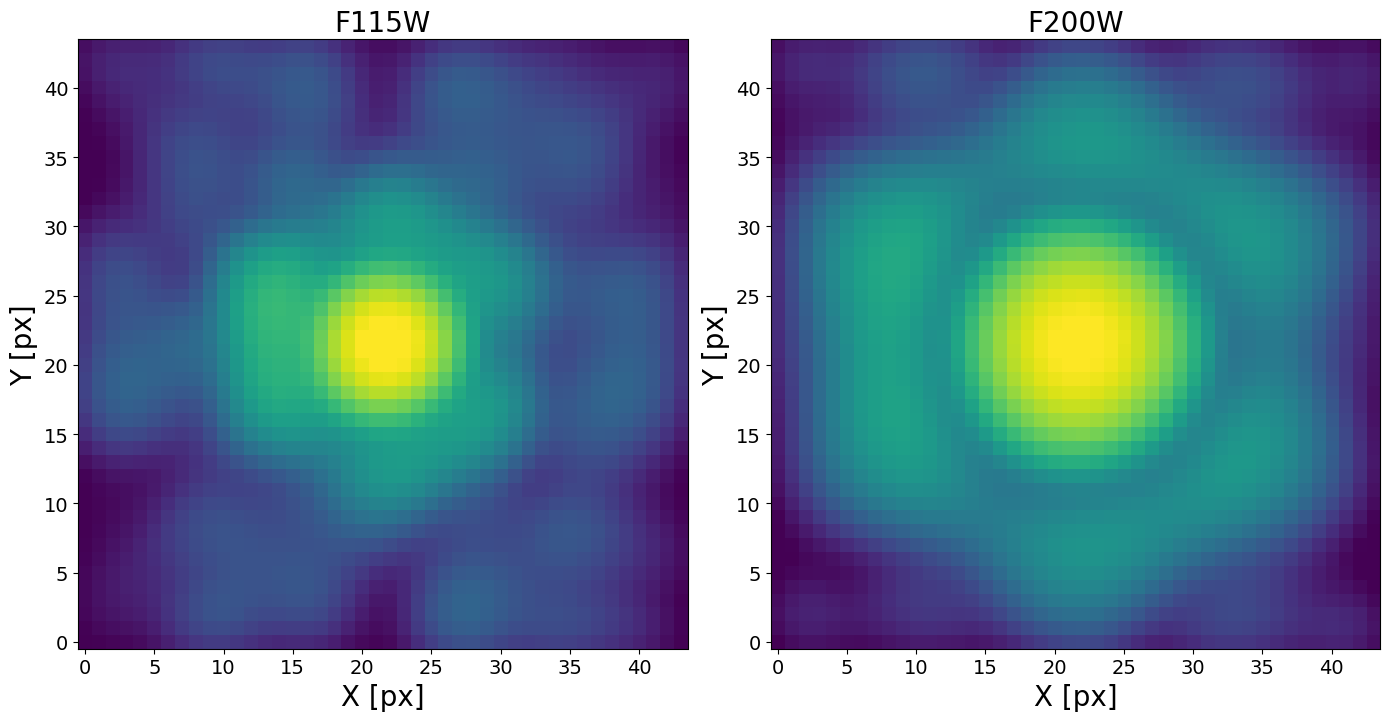

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 14))

for det in dets_short:
    for i, filt in enumerate(filts_short):
        img = dict_psfs_webbpsf[det][filt]['psf model single'].data[0]
        norm_epsf = simple_norm(img, 'log', percent=99.)
        ax[i].imshow(img, norm=norm_epsf)
        ax[i].set_xlabel('X [px]', fontdict=font2)
        ax[i].set_ylabel('Y [px]', fontdict=font2)
        ax[i].set_title(filt, fontdict=font2)

plt.tight_layout()

### PSF grid

In [12]:
for det in dets_short:
    for filt in filts_short:
        create_psf_model(fov=11, num=25, create_grid=True, save_psf=True, detsampled=False)

Creating an oversampled PSF
Using a 11 px fov

Creating a grid of PSF for filter F115W and detector NRCB1


Running instrument: NIRCam, filter: F115W
  Running detector: NRCB1
    Position 1/25: (0, 0) pixels


    Position 1/25 centroid: (21.414239727296515, 21.278125202808827)
    Position 2/25: (0, 512) pixels


    Position 2/25 centroid: (21.507019449724297, 21.202436566606597)
    Position 3/25: (0, 1024) pixels


    Position 3/25 centroid: (21.58885372862631, 21.13053534001794)
    Position 4/25: (0, 1535) pixels


    Position 4/25 centroid: (21.701856933472403, 21.18204895055869)
    Position 5/25: (0, 2047) pixels


    Position 5/25 centroid: (21.80326339792368, 21.236911974969317)
    Position 6/25: (512, 0) pixels


    Position 6/25 centroid: (21.39967375033471, 21.302371393412354)
    Position 7/25: (512, 512) pixels


    Position 7/25 centroid: (21.508867272204093, 21.326103596480415)
    Position 8/25: (512, 1024) pixels


    Position 8/25 centroid: (21.61782479731834, 21.25837782964193)
    Position 9/25: (512, 1535) pixels


    Position 9/25 centroid: (21.741423108288824, 21.309397781890247)
    Position 10/25: (512, 2047) pixels


    Position 10/25 centroid: (21.827956972770725, 21.29722854392913)
    Position 11/25: (1024, 0) pixels


    Position 11/25 centroid: (21.42904087353075, 21.318357379800318)
    Position 12/25: (1024, 512) pixels


    Position 12/25 centroid: (21.504790818328985, 21.36872080255699)
    Position 13/25: (1024, 1024) pixels


    Position 13/25 centroid: (21.610045617107634, 21.350996489683464)
    Position 14/25: (1024, 1535) pixels


    Position 14/25 centroid: (21.7421409066076, 21.376977708555014)
    Position 15/25: (1024, 2047) pixels


    Position 15/25 centroid: (21.865608907888127, 21.352734978464397)
    Position 16/25: (1535, 0) pixels


    Position 16/25 centroid: (21.432868293317124, 21.46838114289654)
    Position 17/25: (1535, 512) pixels


    Position 17/25 centroid: (21.4959782105926, 21.50445280708147)
    Position 18/25: (1535, 1024) pixels


    Position 18/25 centroid: (21.597316422886312, 21.479621413514156)
    Position 19/25: (1535, 1535) pixels


    Position 19/25 centroid: (21.706382937113446, 21.480751333030227)
    Position 20/25: (1535, 2047) pixels


    Position 20/25 centroid: (21.869195680707886, 21.500939148174236)
    Position 21/25: (2047, 0) pixels


    Position 21/25 centroid: (21.45719343925177, 21.696861407829054)
    Position 22/25: (2047, 512) pixels


    Position 22/25 centroid: (21.537440716388865, 21.65280776862352)
    Position 23/25: (2047, 1024) pixels


    Position 23/25 centroid: (21.589573106179035, 21.584019311923374)
    Position 24/25: (2047, 1535) pixels


    Position 24/25 centroid: (21.72034084572062, 21.572958385149004)
    Position 25/25: (2047, 2047) pixels


    Position 25/25 centroid: (21.83278743176354, 21.51145381969895)
  Saving file: nircam_nrcb1_f115w_fovp11_samp4_npsf25.fits


Creating an oversampled PSF
Using a 11 px fov

Creating a grid of PSF for filter F200W and detector NRCB1


Running instrument: NIRCam, filter: F200W
  Running detector: NRCB1
    Position 1/25: (0, 0) pixels


    Position 1/25 centroid: (21.476567857270528, 21.193124910773882)
    Position 2/25: (0, 512) pixels


    Position 2/25 centroid: (21.534426597150937, 21.133717870527924)
    Position 3/25: (0, 1024) pixels


    Position 3/25 centroid: (21.59055224060326, 21.086646943269514)
    Position 4/25: (0, 1535) pixels


    Position 4/25 centroid: (21.720626353067722, 21.1437870027739)
    Position 5/25: (0, 2047) pixels


    Position 5/25 centroid: (21.84034205748881, 21.205165585789203)
    Position 6/25: (512, 0) pixels


    Position 6/25 centroid: (21.45894758436686, 21.218909790717355)
    Position 7/25: (512, 512) pixels


    Position 7/25 centroid: (21.541527669835173, 21.25464826533736)
    Position 8/25: (512, 1024) pixels


    Position 8/25 centroid: (21.62758700371923, 21.213967491532614)
    Position 9/25: (512, 1535) pixels


    Position 9/25 centroid: (21.763529015270517, 21.27904890116982)
    Position 10/25: (512, 2047) pixels


    Position 10/25 centroid: (21.86390055120178, 21.289904729874035)
    Position 11/25: (1024, 0) pixels


    Position 11/25 centroid: (21.48312892903334, 21.24220408389993)
    Position 12/25: (1024, 512) pixels


    Position 12/25 centroid: (21.54132497684362, 21.302630259132883)
    Position 13/25: (1024, 1024) pixels


    Position 13/25 centroid: (21.636891190962604, 21.31041240681749)
    Position 14/25: (1024, 1535) pixels


    Position 14/25 centroid: (21.778226782107318, 21.359623595922052)
    Position 15/25: (1024, 2047) pixels


    Position 15/25 centroid: (21.90864414348056, 21.3640550058928)
    Position 16/25: (1535, 0) pixels


    Position 16/25 centroid: (21.499896950245198, 21.388536045322518)
    Position 17/25: (1535, 512) pixels


    Position 17/25 centroid: (21.55435352231118, 21.435787459884583)
    Position 18/25: (1535, 1024) pixels


    Position 18/25 centroid: (21.65716510309176, 21.434463068411162)
    Position 19/25: (1535, 1535) pixels


    Position 19/25 centroid: (21.770258618303174, 21.46372381812464)
    Position 20/25: (1535, 2047) pixels


    Position 20/25 centroid: (21.93092149825916, 21.505763383105883)
    Position 21/25: (2047, 0) pixels


    Position 21/25 centroid: (21.54285751995154, 21.582234089850818)
    Position 22/25: (2047, 512) pixels


    Position 22/25 centroid: (21.622722242287008, 21.55959257987697)
    Position 23/25: (2047, 1024) pixels


    Position 23/25 centroid: (21.67688800884963, 21.526382612306623)
    Position 24/25: (2047, 1535) pixels


    Position 24/25 centroid: (21.802850619326367, 21.53530766147755)
    Position 25/25: (2047, 2047) pixels


    Position 25/25 centroid: (21.900911542326913, 21.49862255103234)
  Saving file: nircam_nrcb1_f200w_fovp11_samp4_npsf25.fits


## Display the PSFs grid

We show for 1 filter (**F115W**) the grid of PSFs and the difference from the mean

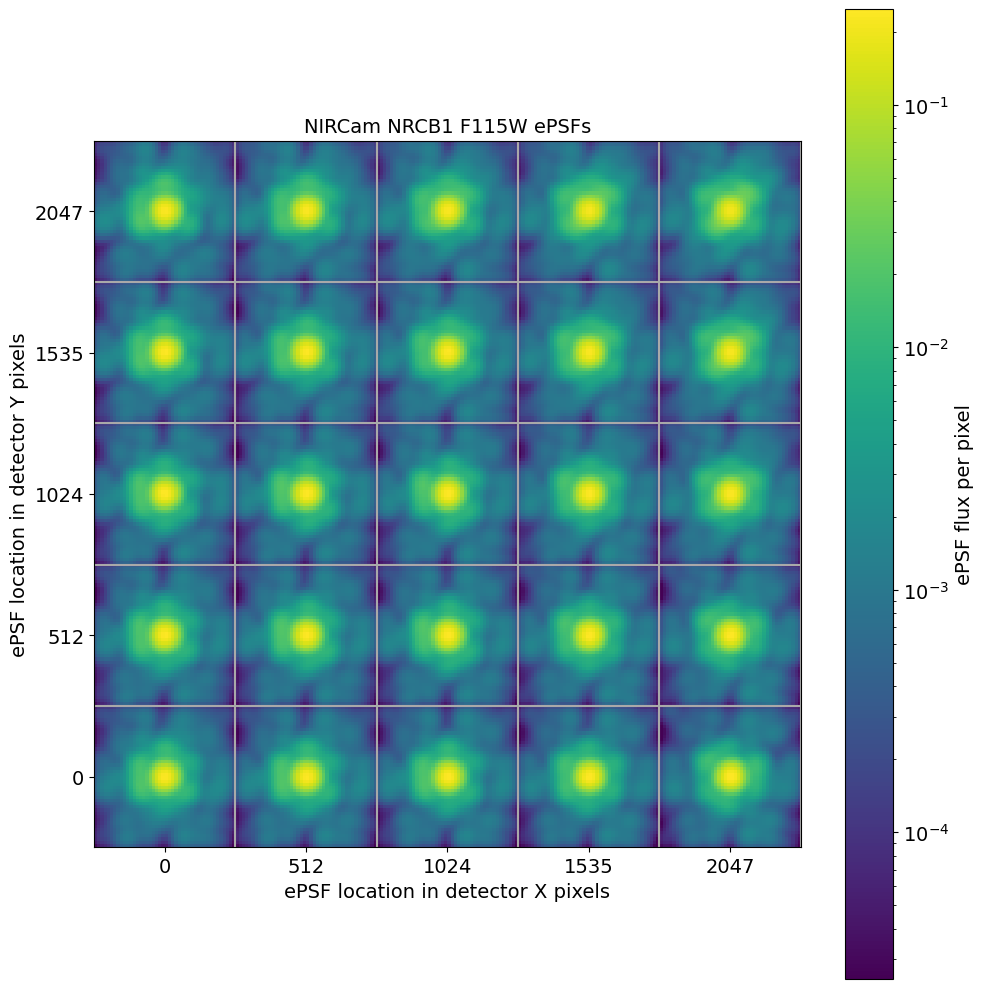

In [13]:
griddedpsfmodel = dict_psfs_webbpsf[dets_short[0]][filts_short[0]]['psf model grid']
fig = griddedpsfmodel.plot_grid(figsize=(10, 10))

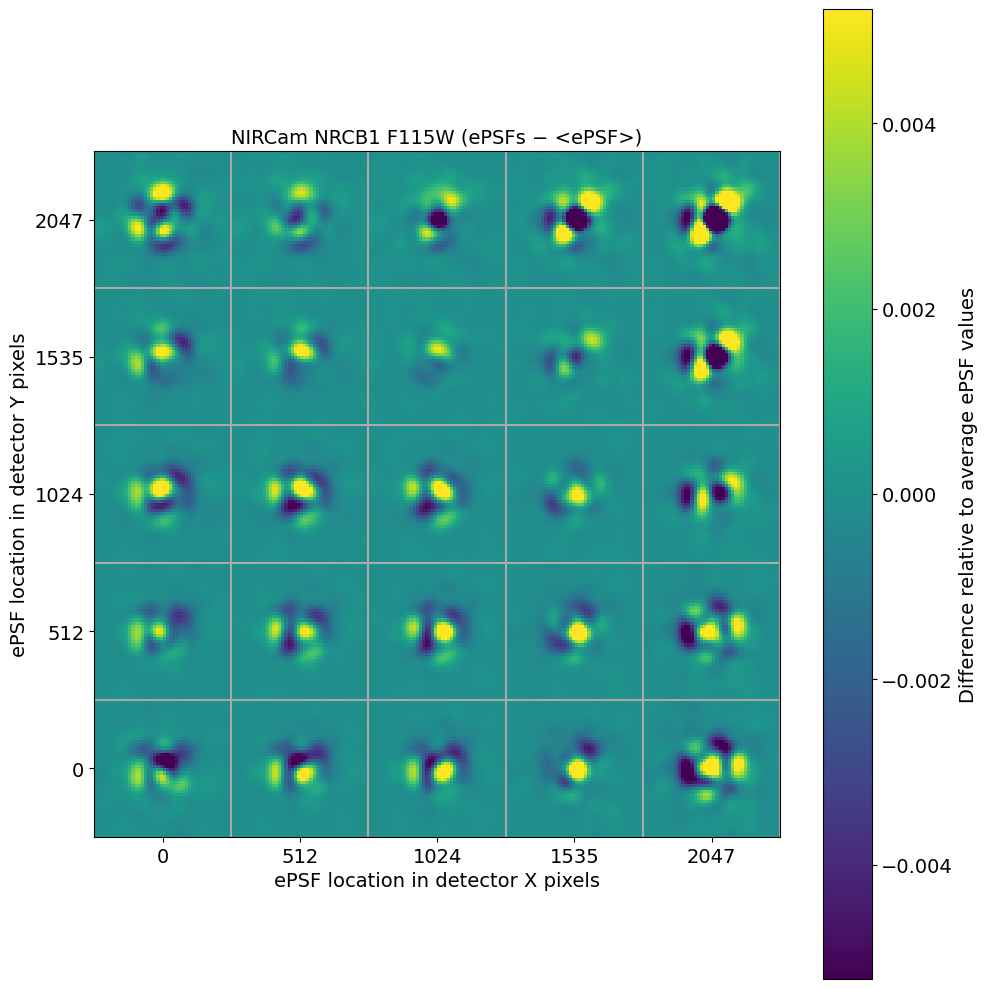

In [14]:
fig = griddedpsfmodel.plot_grid(figsize=(10, 10), deltas=True, cmap='viridis', vmax_scale=0.3)

## II. Create the PSF model building an Effective PSF (ePSF)

More information on the photutils Effective PSF can be found [here](https://photutils.readthedocs.io/en/stable/user_guide/epsf.html).

* Select the stars from the images we want to use for building the PSF. We use the [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) function to find bright stars in the images (setting a high detection threshold). [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder) detects stars in an image using the DAOFIND ([Stetson 1987](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract)) algorithm. DAOFIND searches images for local density maxima that have a peak amplitude greater than `threshold` (approximately; threshold is applied to a convolved image) and have a size and shape similar to the defined 2D Gaussian kernel. \
 **Note**: The threshold and the maximum distance to the closest neighbour depend on the user science case (i.e.; number of stars in the field of view, crowding, number of bright sources, minimum number of stars required to build the ePSF, etc.) and must be modified accordingly. 
* Build the effective PSF (excluding objects for which the bounding box exceed the detector edge) using [EPSBuilder](https://photutils.readthedocs.io/en/stable/api/photutils.psf.EPSFBuilder.html#photutils.psf.EPSFBuilder) function.

We create a dictionary that contains the effective PSF for the detectors and filters selected above.

In [15]:
dict_psfs_epsf = {}

for det in dets_short:
    dict_psfs_epsf.setdefault(det, {})
    for j, filt in enumerate(filts_short):
        dict_psfs_epsf[det].setdefault(filt, {})

        dict_psfs_epsf[det][filt]['table psf stars'] = {}
        dict_psfs_epsf[det][filt]['epsf single'] = {}
        dict_psfs_epsf[det][filt]['epsf grid'] = {}

        for i in np.arange(0, len(dict_images[det][filt]['images']), 1):
            dict_psfs_epsf[det][filt]['table psf stars'][i + 1] = None
            dict_psfs_epsf[det][filt]['epsf single'][i + 1] = None
            dict_psfs_epsf[det][filt]['epsf grid'][i + 1] = None

Note that the unit of the Level-2 and Level-3 Images from the pipeline is MJy/sr (hence a surface brightness). The actual unit of the image can be checked from the header keyword **BUNIT**. The scalar conversion constant is copied to the header keyword **PHOTMJSR**, which gives the conversion from DN/s to MJy/steradian. For our analysis we revert back to DN/s.

In [16]:
def find_stars_epsf(img_num, filt_num, det='NRCA1', filt='F070W', dist_sel=False):

    bkgrms = MADStdBackgroundRMS()
    mmm_bkg = MMMBackground()

    image = fits.open(dict_images[det][filt]['images'][img_num])
    data_sb = image[1].data
    imh = image[1].header

    print(f"Finding PSF stars on image {img_num + 1} of filter {filt}, detector {det}")

    data = data_sb / imh['PHOTMJSR']
    units = imh['BUNIT']
    print(f"Conversion factor from {units} to DN/s for filter {filt}: {imh['PHOTMJSR']}")

    sigma_psf = dict_utils[filt]['psf fwhm']

    print(f"FWHM for the filter {filt}: {sigma_psf} px")

    std = bkgrms(data)
    bkg = mmm_bkg(data)
    daofind = DAOStarFinder(threshold=th[filt_num] * std + bkg, fwhm=sigma_psf, roundhi=1.0, roundlo=-1.0,
                            sharplo=0.30, sharphi=1.40)

    psf_stars = daofind(data)
    dict_psfs_epsf[det][filt]['table psf stars'][img_num + 1] = psf_stars
    
    if dist_sel:

        print("")
        print("Calculating closest neigbhour distance")

        d = []

        daofind_tot = DAOStarFinder(threshold=10 * std + bkg, fwhm=sigma_psf, roundhi=1.0, roundlo=-1.0,
                                    sharplo=0.30, sharphi=1.40)

        stars_tot = daofind_tot(data)

        x_tot = stars_tot['xcentroid']
        y_tot = stars_tot['ycentroid']

        for xx, yy in zip(psf_stars['xcentroid'], psf_stars['ycentroid']):

            sep = []
            dist = np.sqrt((x_tot - xx)**2 + (y_tot - yy)**2)
            sep = np.sort(dist)[1:2][0]
            d.append(sep)

        psf_stars['min distance'] = d
        mask_dist = (psf_stars['min distance'] > min_sep[filt_num])

        psf_stars = psf_stars[mask_dist]

        dict_psfs_epsf[det][filt]['table psf stars'][img_num + 1] = psf_stars

        print("Minimum distance required:", min_sep[filt_num], "px")
        print("")
        print(f"Number of isolated sources found in the image used to build ePSF for {filt}: {len(psf_stars)}")
        print("-----------------------------------------------------")
        print("")
    else:
        print("")
        print(f"Number of sources used to build ePSF for {filt}: {len(psf_stars)}")
        print("--------------------------------------------")
        print("")

In [17]:
tic = time.perf_counter()

th = [700, 500]  # threshold level for the two filters (length must match number of filters analyzed)
min_sep = [10, 10]  # minimum separation acceptable for ePSF stars from closest neighbour

for det in dets_short:
    for j, filt in enumerate(filts_short):
        for i in np.arange(0, len(dict_images[det][filt]['images']), 1):

            find_stars_epsf(i, j, det=det, filt=filt, dist_sel=False)

toc = time.perf_counter()

print("Elapsed Time for finding stars:", toc - tic)

Finding PSF stars on image 1 of filter F115W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
FWHM for the filter F115W: 1.298 px



Number of sources used to build ePSF for F115W: 1306
--------------------------------------------

Finding PSF stars on image 2 of filter F115W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
FWHM for the filter F115W: 1.298 px



Number of sources used to build ePSF for F115W: 1324
--------------------------------------------

Finding PSF stars on image 3 of filter F115W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
FWHM for the filter F115W: 1.298 px



Number of sources used to build ePSF for F115W: 1307
--------------------------------------------

Finding PSF stars on image 4 of filter F115W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
FWHM for the filter F115W: 1.298 px



Number of sources used to build ePSF for F115W: 1316
--------------------------------------------

Finding PSF stars on image 1 of filter F200W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
FWHM for the filter F200W: 2.141 px



Number of sources used to build ePSF for F200W: 1276
--------------------------------------------

Finding PSF stars on image 2 of filter F200W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
FWHM for the filter F200W: 2.141 px



Number of sources used to build ePSF for F200W: 1287
--------------------------------------------

Finding PSF stars on image 3 of filter F200W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
FWHM for the filter F200W: 2.141 px



Number of sources used to build ePSF for F200W: 1291
--------------------------------------------

Finding PSF stars on image 4 of filter F200W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
FWHM for the filter F200W: 2.141 px



Number of sources used to build ePSF for F200W: 1278
--------------------------------------------

Elapsed Time for finding stars: 11.771910853000009


### II. Build Effective PSF

In [18]:
def build_epsf(det='NRCA1', filt='F070W'):
    
    mmm_bkg = MMMBackground()
    
    image = fits.open(dict_images[det][filt]['images'][i])
    data_sb = image[1].data
    imh = image[1].header

    data = data_sb / imh['PHOTMJSR']

    hsize = (sizes[j] - 1) / 2

    x = dict_psfs_epsf[det][filt]['table psf stars'][i + 1]['xcentroid']
    y = dict_psfs_epsf[det][filt]['table psf stars'][i + 1]['ycentroid']
    mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) & (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

    stars_tbl = Table()
    stars_tbl['x'] = x[mask]
    stars_tbl['y'] = y[mask]

    bkg = mmm_bkg(data)

    data_bkgsub = data.copy()

    data_bkgsub -= bkg

    nddata = NDData(data=data_bkgsub)
    stars = extract_stars(nddata, stars_tbl, size=sizes[j])

    print(f"Creating ePSF for image {i + 1} of filter {filt}, detector {det}")

    epsf_builder = EPSFBuilder(oversampling=oversample, maxiters=3, progress_bar=False)

    epsf, fitted_stars = epsf_builder(stars)
    dict_psfs_epsf[det][filt]['epsf single'][i + 1] = epsf

**Note**: here we limit the maximum number of iterations to 3 (to limit it’s run time), but in practice one should use about 10 or more iterations.

In [19]:
tic = time.perf_counter()

sizes = [11, 11]  # size of the cutout (extract region) for each PSF star - must match number of filters analyzed
oversample = 4

for det in dets_short:
    for j, filt in enumerate(filts_short):
        for i in np.arange(0, len(dict_images[det][filt]['images']), 1):
            with warnings.catch_warnings():
                # ignore warnings about stars close to image edge
                warnings.simplefilter("ignore", category=AstropyUserWarning) 
                build_epsf(det=det, filt=filt)

toc = time.perf_counter()

print("Time to build the Effective PSF:", toc - tic)

Creating ePSF for image 1 of filter F115W, detector NRCB1


Creating ePSF for image 2 of filter F115W, detector NRCB1


Creating ePSF for image 3 of filter F115W, detector NRCB1


Creating ePSF for image 4 of filter F115W, detector NRCB1


Creating ePSF for image 1 of filter F200W, detector NRCB1


Creating ePSF for image 2 of filter F200W, detector NRCB1


Creating ePSF for image 3 of filter F200W, detector NRCB1


Creating ePSF for image 4 of filter F200W, detector NRCB1


Time to build the Effective PSF: 185.06032837499993


## Display the ePSFs 

We display only 1 ePSF for each filter

2024-11-12 19:42:36,277 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:42:36,279 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:42:36,312 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:42:36,330 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:42:36,364 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:42:36,446 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:42:36,447 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:42:36,468 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:42:36,474 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:42:36,494 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


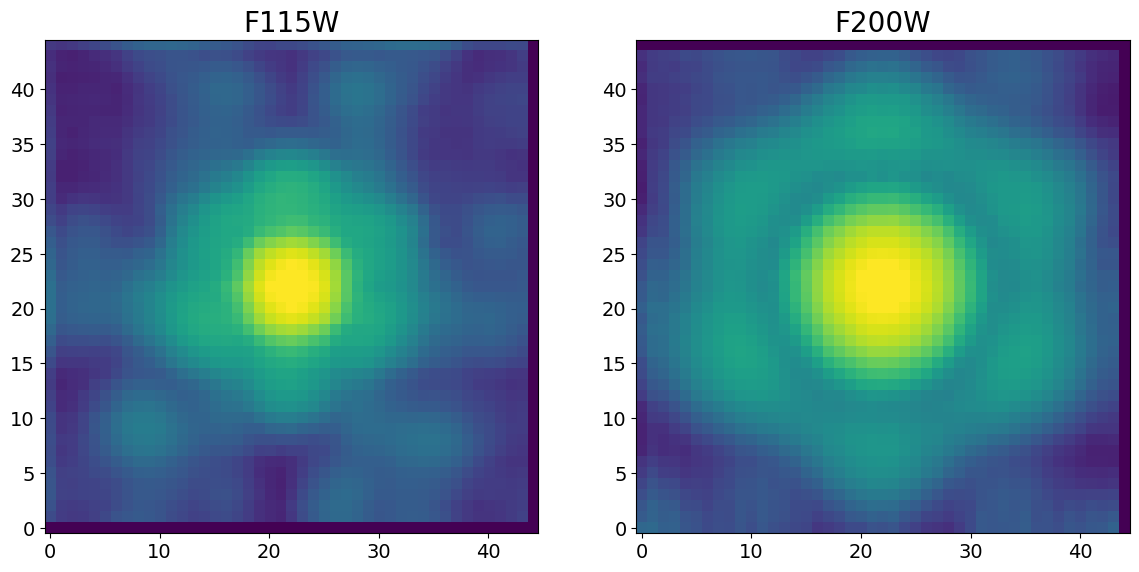

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 14))

for det in dets_short:
    for i, filt in enumerate(filts_short):
        img = dict_psfs_epsf[det][filt]['epsf single'][i + 1].data
        norm_epsf = simple_norm(img, 'log', percent=99.)
        ax[i].imshow(img, norm=norm_epsf)
        ax[i].set_title(filt, fontdict=font2)

## Work in Progress - Build a grid of effective PSF

Two functions:
* count PSF stars in the grid 
* create a gridded ePSF

The purpose of the first function is to count how many good PSF stars are in each sub-region defined by the grid number N. The function should start from the number provided by the user and iterate until the minimum grid size 2x2. Depending on the number of PSF stars that the users want in each cell of the grid, they can choose the appropriate grid size or modify the threshold values for the stars detection, selected when creating the single ePSF (in the **Finding stars** cell above).

The second function creates a grid of PSFs with EPSFBuilder. The function will return a a GriddedEPSFModel object containing a 3D array of N  ×  n  ×  n. The 3D array represents the N number of 2D n  ×  n ePSFs created. It should include a grid_xypos key which will state the position of the PSF on the detector for each of the PSFs. The order of the tuples in grid_xypos refers to the number the PSF is in the 3D array.

### I. Counting PSF stars in each region of the grid

In [21]:
def count_PSFstars_grid(grid_points=5, size=15, min_numpsf=40):

    num_grid_calc = np.arange(2, grid_points + 1, 1)
    num_grid_calc = num_grid_calc[::-1]

    for num in num_grid_calc:
        print(f"Calculating the number of PSF stars in a {num} x {num} grid")
        print("")

        image = fits.open(dict_images[det][filt]['images'][i])
        data_sb = image[1].data

        points = np.int16((data_sb.shape[0] / num) / 2)
        x_center = np.arange(points, 2 * points * (num), 2 * points)
        y_center = np.arange(points, 2 * points * (num), 2 * points)

        centers = np.array(np.meshgrid(x_center, y_center)).T.reshape(-1, 2)

        for n, val in enumerate(centers):

            x = dict_psfs_epsf[det][filt]['table psf stars'][i + 1]['xcentroid']
            y = dict_psfs_epsf[det][filt]['table psf stars'][i + 1]['ycentroid']
            # flux = dict_psfs_epsf[det][filt]['table psf stars'][i + 1]['flux']

            half_size = (size - 1) / 2

            lim1 = val[0] - points + half_size
            lim2 = val[0] + points - half_size
            lim3 = val[1] - points + half_size
            lim4 = val[1] + points - half_size

            test = (x > lim1) & (x < lim2) & (y > lim3) & (y < lim4)

            if np.count_nonzero(test) < min_numpsf:
                print(f"Center Coordinates of grid cell {i + 1} are ({val[0]}, {val[1]}) --- Not enough PSF stars in the cell (number of PSF stars < {min_numpsf})")

            else:
                print(f"Center Coordinate of grid cell {n + 1} are ({val[0]}, {val[1]}) --- Number of PSF stars: {np.count_nonzero(test)}")                
        print("")

In [22]:
for det in dets_short:
    for j, filt in enumerate(filts_short):
        for i in np.arange(0, len(dict_images[det][filt]['images']), 1):

            print(f"Analyzing image {i + 1} of filter {filt}, detector {det}")
            print("")

            count_PSFstars_grid(grid_points=5, size=15, min_numpsf=40)

Analyzing image 1 of filter F115W, detector NRCB1

Calculating the number of PSF stars in a 5 x 5 grid

Center Coordinate of grid cell 1 are (204, 204) --- Number of PSF stars: 72
Center Coordinate of grid cell 2 are (204, 612) --- Number of PSF stars: 46
Center Coordinate of grid cell 3 are (204, 1020) --- Number of PSF stars: 51
Center Coordinate of grid cell 4 are (204, 1428) --- Number of PSF stars: 48
Center Coordinate of grid cell 5 are (204, 1836) --- Number of PSF stars: 51
Center Coordinate of grid cell 6 are (612, 204) --- Number of PSF stars: 55
Center Coordinate of grid cell 7 are (612, 612) --- Number of PSF stars: 51
Center Coordinate of grid cell 8 are (612, 1020) --- Number of PSF stars: 45
Center Coordinate of grid cell 9 are (612, 1428) --- Number of PSF stars: 40
Center Coordinate of grid cell 10 are (612, 1836) --- Number of PSF stars: 57
Center Coordinate of grid cell 11 are (1020, 204) --- Number of PSF stars: 47
Center Coordinate of grid cell 12 are (1020, 612) -

## TODO - Create a grid of ePSF

Here goes the function that creates a grid of ePSF that can be saved in the epsf dictionary.

## TODO - Use the ePSF grid to perturbate the WebbPSF model

Here goes the function that create a grid of PSF models obtained perturbating the WebbPSF PSF models using the ePSF grid created above.

## Perform PSF photometry

We perform the PSF photometry on the images, saving by default the output catalogs and the residual images in the dictionary created below. It is also possible to save the output catalogs (pickles pandas object) and residual images (fits files) in the current directory using the parameters `save_output` and `save_residuals`. 

In [23]:
dict_phot = {}

for det in dets_short:
    dict_phot.setdefault(det, {})
    for j, filt in enumerate(filts_short):
        dict_phot[det].setdefault(filt, {})

        dict_phot[det][filt]['residual images'] = {}
        dict_phot[det][filt]['output photometry tables'] = {}

        for i in np.arange(0, len(dict_images[det][filt]['images']), 1):
            dict_phot[det][filt]['residual images'][i + 1] = None
            dict_phot[det][filt]['output photometry tables'][i + 1] = None

**Note**: to speed up the notebook, we use a high threshold in the finding algorithm (threshold ~ 2000) and we will use in the analyis below the catalogs obtained with a sigma threshold = 10 from a previous reduction run. To perform a meaningful data reduction, the user should modify the threshold accordingly. 

Here we use as PSF model the grid of WebbPSF PSFs, but the users can change the model and use the others available (i.e., single WebbPSF PSF, single ePSF) modifying the `psf` parameter in the function.

In [24]:
def psf_phot(det='NRCA1', filt='F070W', th=2000, psf='grid_webbpsf', save_residuals=False, save_output=False):

    bkgrms = MADStdBackgroundRMS()
    mmm_bkg = MMMBackground()
    fitter = LevMarLSQFitter()

    im = fits.open(dict_images[det][filt]['images'][i])
    imh = im[1].header
    data_sb = im[1].data

    d = im[0].header['DETECTOR']
    prim_dith_pos = im[0].header['PATT_NUM']
    prim_dith_num = im[0].header['NUMDTHPT']
    subpx_dith_pos = im[0].header['SUBPXNUM']
    subpx_dith_num = im[0].header['SUBPXPNS']

    data = data_sb / imh['PHOTMJSR']

    units = imh['BUNIT']
    print(f"Conversion factor from {units} to DN/s for filter {filt}: {imh['PHOTMJSR']}")
    print("Applying conversion to the data")
            
    sigma_psf = dict_utils[filt]['psf fwhm']
    print(f"FWHM for the filter {filt}: {sigma_psf}")
    
    std = bkgrms(data)
    bkg = mmm_bkg(data)
    
    daofind = DAOStarFinder(threshold=th * std + bkg, fwhm=sigma_psf, roundhi=1.0, roundlo=-1.0,
                            sharplo=0.30, sharphi=1.40)
    
    grouper = SourceGrouper(5.0 * sigma_psf)
    
    # grid PSF

    if psf == 'grid_webbpsf':
        print("Using as PSF model WebbPSF PSFs grid")
        psf_model = dict_psfs_webbpsf[det][filt]['psf model grid'].copy()

    # single psf:

    if psf == 'single_webbpsf':
        print("Using as PSF model WebbPSF single PSF")
        psf_model = dict_psfs_webbpsf[det][filt]['psf model single'].copy()

    # epsf:

    if psf == 'single_epsf':
        print("Using as PSF model single ePSF")
        psf_model = dict_psfs_epsf[det][filt]['epsf single'][i + 1].copy()

    print(f"Performing the photometry on image {i + 1} of filter {filt}, detector {det}")
            
    tic = time.perf_counter()

    data_sub = data - mmm_bkg(data)
    psf_shape = (11, 11)
    
    phot = IterativePSFPhotometry(psf_model, psf_shape, daofind,
                                  grouper=grouper, fitter=fitter,
                                  fitter_maxiters=500,
                                  maxiters=2, aperture_radius=ap_radius[j])
    result = phot(data_sub)
    
    toc = time.perf_counter()

    dtime = (toc - tic)
    print(f"Time needed to perform photometry on image {i + 1}: {dtime:.2f} sec")
    print(f"Number of sources detected in image {i + 1} for filter {filt}: {len(result)}")
        
    residual_image = phot.make_residual_image(data_sub, psf_shape=psf_shape)
                            
    dict_phot[det][filt]['residual images'][i + 1] = residual_image
    dict_phot[det][filt]['output photometry tables'][i + 1] = result

    # save the residual images as fits file:

    if save_residuals:
        hdu = fits.PrimaryHDU(residual_image)
        hdul = fits.HDUList([hdu])
        residual_outname = f'residual_{d}_{filt}_webbPSF_gridPSF_{prim_dith_pos}of{prim_dith_num}_{subpx_dith_pos}of{subpx_dith_num}.fits'

        dir_output_phot = './'

        hdul.writeto(os.path.join(dir_output_phot, residual_outname))
        outname = 'phot_{d}_{filt}_webbPSF_gridPSF_level2_{prim_dith_pos}of{prim_dith_num}_{subpx_dith_pos}of{subpx_dith_num}.pkl'

    # save the output photometry Tables
    if save_output:
        tab = result.to_pandas()
        tab.to_pickle(os.path.join(dir_output_phot, outname))

In [25]:
tic_tot = time.perf_counter()

ap_radius = [3.0, 3.5]  # must match the number of filters analyzed

if glob.glob('./*residual*.fits'):
    print("Deleting Residual images from directory")
    files = glob.glob('./residual*.fits')
    for file in files:
        os.remove(file)

for det in dets_short:
    for j, filt in enumerate(filts_short):
        for i in np.arange(0, len(dict_images[det][filt]['images']), 1):
            
            psf_phot(det=det, filt=filt, th=2000, psf='grid_webbpsf', save_residuals=True, save_output=False) 

toc_tot = time.perf_counter()
number = len(filts_short) * len(dict_images[det][filt]['images'])
dtime = (toc_tot - tic_tot)
print(f"Time elapsed to perform the photometry of the {number} images: {dtime:.2f} sec")

Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
Applying conversion to the data
FWHM for the filter F115W: 1.298


Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 1 of filter F115W, detector NRCB1


2024-11-12 19:43:00,221 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1423: AstropyUserWarning: One or more fit(s) may not have converged. Please check the "flags" column in the output table.
  warnings.warn('One or more fit(s) may not have converged. Please '



Time needed to perform photometry on image 1: 22.35 sec
Number of sources detected in image 1 for filter F115W: 554


Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
Applying conversion to the data
FWHM for the filter F115W: 1.298


Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 2 of filter F115W, detector NRCB1


2024-11-12 19:43:58,410 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1243: AstropyUserWarning: Some groups have more than 25 sources. Fitting such groups may take a long time and be error-prone. You may want to consider using different `SourceGrouper` parameters or changing the "group_id" column in "init_params".
  warnings.warn('Some groups have more than 25 sources. Fitting '



2024-11-12 19:43:58,411 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1423: AstropyUserWarning: One or more fit(s) may not have converged. Please check the "flags" column in the output table.
  warnings.warn('One or more fit(s) may not have converged. Please '



Time needed to perform photometry on image 2: 56.63 sec
Number of sources detected in image 2 for filter F115W: 562


Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
Applying conversion to the data
FWHM for the filter F115W: 1.298


Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 3 of filter F115W, detector NRCB1


2024-11-12 19:44:25,053 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1423: AstropyUserWarning: One or more fit(s) may not have converged. Please check the "flags" column in the output table.
  warnings.warn('One or more fit(s) may not have converged. Please '



Time needed to perform photometry on image 3: 25.12 sec
Number of sources detected in image 3 for filter F115W: 588


Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
Applying conversion to the data
FWHM for the filter F115W: 1.298


Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 4 of filter F115W, detector NRCB1


2024-11-12 19:44:44,048 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1423: AstropyUserWarning: One or more fit(s) may not have converged. Please check the "flags" column in the output table.
  warnings.warn('One or more fit(s) may not have converged. Please '



Time needed to perform photometry on image 4: 17.52 sec
Number of sources detected in image 4 for filter F115W: 571


Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
Applying conversion to the data
FWHM for the filter F200W: 2.141


Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 1 of filter F200W, detector NRCB1


2024-11-12 19:46:19,473 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1243: AstropyUserWarning: Some groups have more than 25 sources. Fitting such groups may take a long time and be error-prone. You may want to consider using different `SourceGrouper` parameters or changing the "group_id" column in "init_params".
  warnings.warn('Some groups have more than 25 sources. Fitting '



2024-11-12 19:46:19,474 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1423: AstropyUserWarning: One or more fit(s) may not have converged. Please check the "flags" column in the output table.
  warnings.warn('One or more fit(s) may not have converged. Please '



Time needed to perform photometry on image 1: 93.86 sec
Number of sources detected in image 1 for filter F200W: 414


Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
Applying conversion to the data
FWHM for the filter F200W: 2.141


Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 2 of filter F200W, detector NRCB1


2024-11-12 19:48:19,829 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1243: AstropyUserWarning: Some groups have more than 25 sources. Fitting such groups may take a long time and be error-prone. You may want to consider using different `SourceGrouper` parameters or changing the "group_id" column in "init_params".
  warnings.warn('Some groups have more than 25 sources. Fitting '



2024-11-12 19:48:19,830 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1423: AstropyUserWarning: One or more fit(s) may not have converged. Please check the "flags" column in the output table.
  warnings.warn('One or more fit(s) may not have converged. Please '



Time needed to perform photometry on image 2: 118.84 sec
Number of sources detected in image 2 for filter F200W: 437


Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
Applying conversion to the data
FWHM for the filter F200W: 2.141


Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 3 of filter F200W, detector NRCB1


2024-11-12 19:49:54,200 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1243: AstropyUserWarning: Some groups have more than 25 sources. Fitting such groups may take a long time and be error-prone. You may want to consider using different `SourceGrouper` parameters or changing the "group_id" column in "init_params".
  warnings.warn('Some groups have more than 25 sources. Fitting '



2024-11-12 19:49:54,200 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1423: AstropyUserWarning: One or more fit(s) may not have converged. Please check the "flags" column in the output table.
  warnings.warn('One or more fit(s) may not have converged. Please '



Time needed to perform photometry on image 3: 92.87 sec
Number of sources detected in image 3 for filter F200W: 430


Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
Applying conversion to the data
FWHM for the filter F200W: 2.141


Using as PSF model WebbPSF PSFs grid
Performing the photometry on image 4 of filter F200W, detector NRCB1


2024-11-12 19:51:33,213 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1243: AstropyUserWarning: Some groups have more than 25 sources. Fitting such groups may take a long time and be error-prone. You may want to consider using different `SourceGrouper` parameters or changing the "group_id" column in "init_params".
  warnings.warn('Some groups have more than 25 sources. Fitting '



2024-11-12 19:51:33,213 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.10/x64/lib/python3.11/site-packages/photutils/psf/photometry.py:1423: AstropyUserWarning: One or more fit(s) may not have converged. Please check the "flags" column in the output table.
  warnings.warn('One or more fit(s) may not have converged. Please '



Time needed to perform photometry on image 4: 97.53 sec
Number of sources detected in image 4 for filter F200W: 425


Time elapsed to perform the photometry of the 8 images: 536.79 sec


## Output Photometry Table

In [26]:
dict_phot['NRCB1']['F115W']['output photometry tables'][1]

<QTable length=554>
  id  group_id group_size ...         qfit                 cfit          flags
int64  int64     int64    ...       float64              float64         int64
----- -------- ---------- ... ------------------- ---------------------- -----
    1        1          1 ... 0.09021600166003052  0.0012036314536959406     0
    2        2          1 ...  0.1088787402941081  0.0005604606941135923     0
    3        3          1 ... 0.10732397374445889  0.0003093668483192827     0
    4        4          1 ... 0.10091849363830661  -0.001334583898956049     0
    5        5          1 ... 0.11181619115626917 -0.0014999925998494831     0
    6        6          1 ...   1.668412270455276   -0.10035874874360234     0
    7        7          1 ... 0.14094033415897547  0.0009274358228568666     0
    8        8          1 ... 0.43892987563614033   -0.04546042633602488     0
    9        9          1 ... 0.10975648659058734 -0.0009915989382429762     0
  ...      ...        ... ...                 ...                    ...   ...
  545      511          1 ...  2.4641346315043484  -0.023973685352381268     0
  546      512          1 ... -2.4398019274180003    -0.5538842944780792     4
  547      513          1 ...  1.0257023339947773     0.0397286401694784     0
  548      514          1 ... -2.4686702983667175    -0.5047816257927965     4
  549      515          1 ...  -2.322872308516039    -0.4508370074842579     4
  550      516          1 ... -2.3238584171217633    -0.4435638637623684     4
  551      517          1 ...  1.5758312756084738   0.034472545076315135     0
  552      518          1 ...  1.9542350320542126   -0.06665453371072534     0
  553      519          2 ...   4.085398756857934   -0.04078410865567663     0
  554      519          2 ...   6.906070065033245 -0.0037225645231778915     0

## Display subtracted image

As an example, we show the comparison between one science image and the residual image after the data reduction for both filters. Note that the residual image is obtained from the photometry run in the cell above with a very high detection threshold.

2024-11-12 19:51:33,815 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:33,816 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:33,831 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:33,836 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:33,862 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,005 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,015 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,017 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,106 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,116 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,117 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,213 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,223 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,322 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,331 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,768 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,769 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,770 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,852 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,853 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,862 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,863 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,868 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,949 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,958 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:34,960 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:35,051 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:35,060 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:35,154 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:35,163 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


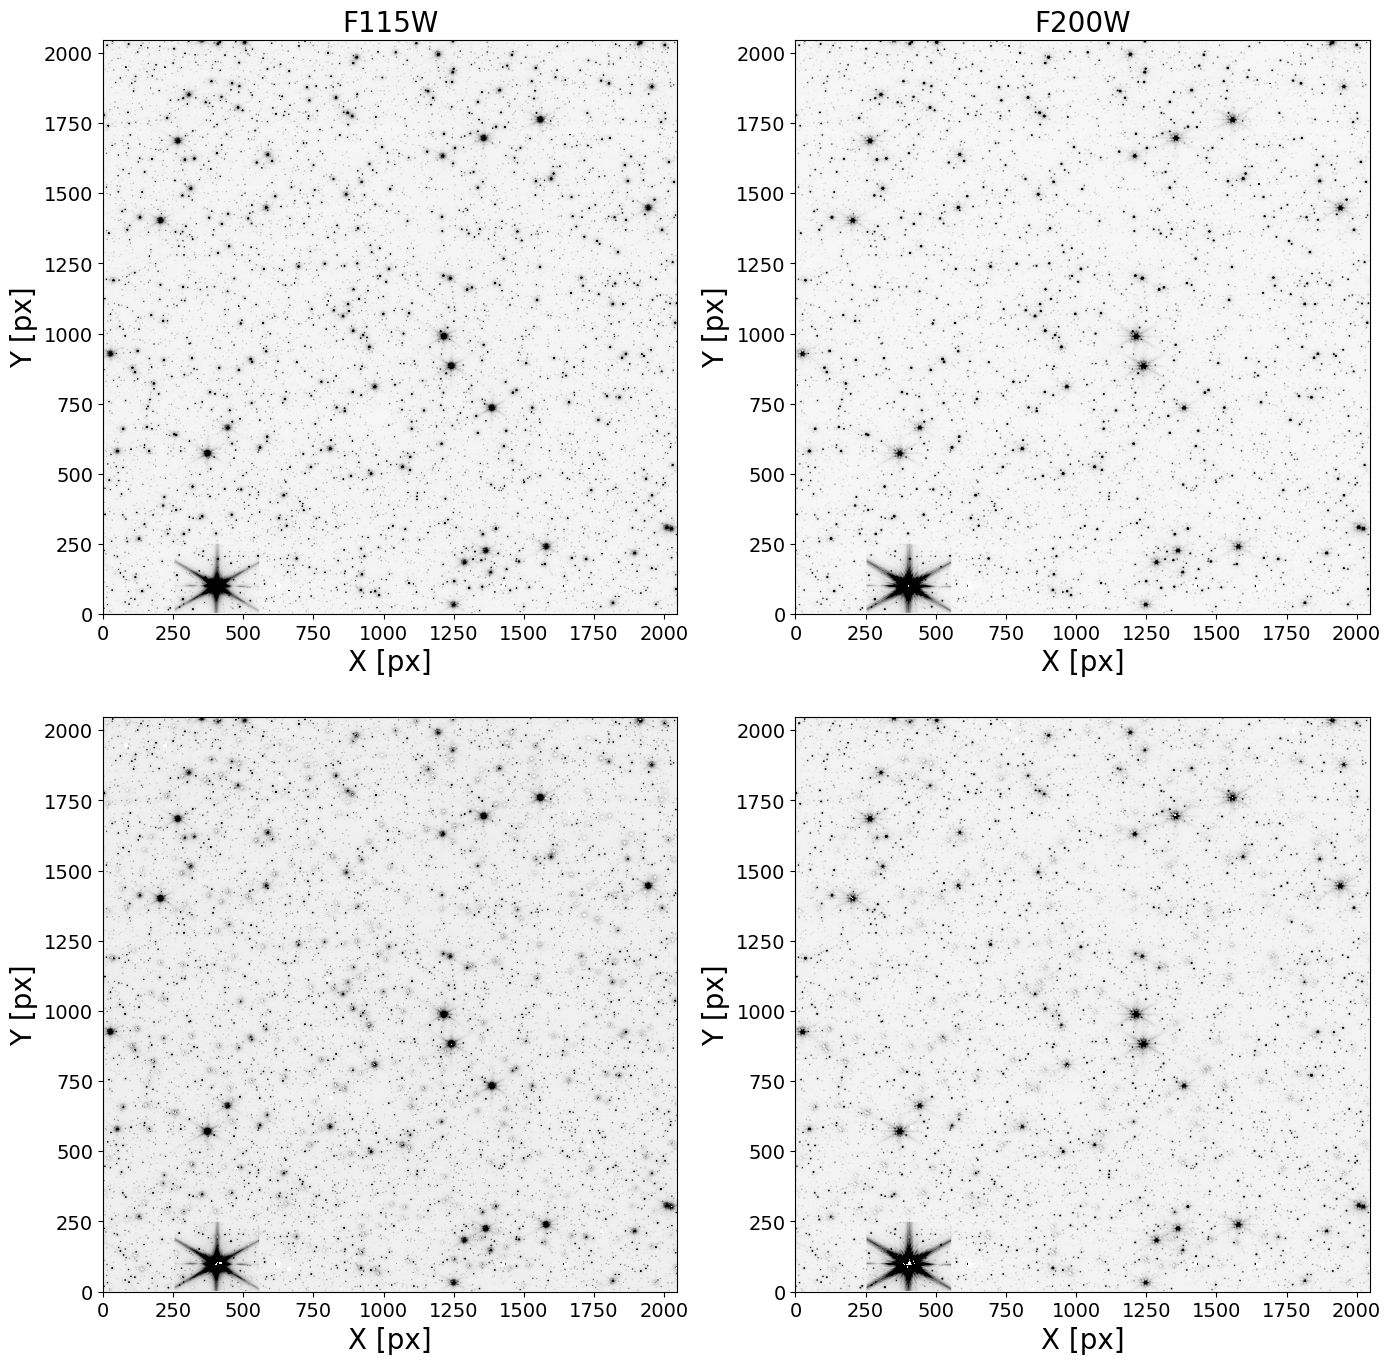

In [27]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14, 14))

for det in dets_short:
    for i, filt in enumerate(filts_short):
        image = fits.open(dict_images[det][filt]['images'][0])
        data_sb = image[1].data
        norm = simple_norm(data_sb, 'sqrt', percent=99.)
        ax[0, i].imshow(data_sb, norm=norm, cmap='Greys')
        ax[0, i].set_xlabel("X [px]", fontdict=font2)
        ax[0, i].set_ylabel("Y [px]", fontdict=font2)
        ax[0, i].set_title(filt, fontdict=font2)

for det in dets_short:
    for i, filt in enumerate(filts_short):
        res = dict_phot[det][filt]['residual images'][1]
        norm = simple_norm(res, 'sqrt', percent=99.)
        ax[1, i].imshow(res, norm=norm, cmap='Greys')
        ax[1, i].set_xlabel("X [px]", fontdict=font2)
        ax[1, i].set_ylabel("Y [px]", fontdict=font2)

plt.tight_layout()

## Part II - Data Analysis

**Note**: here we use the reduction obtained using a grid of WebbPSF PSFs as PSF models. The users can perform the data analysis using different PSF models (single PSF model, PSF grid, etc.) and compare the results. 

## Load Tables with PSF Photometry

In [28]:
if not glob.glob('./*phot*gridPSF*.pkl'):

    print("Downloading Photometry Output")

    boxlink_cat_f115w = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/stellar_photometry/phot_cat_F115W.tar.gz'
    boxfile_cat_f115w = './phot_cat_F115W.tar.gz'
    request.urlretrieve(boxlink_cat_f115w, boxfile_cat_f115w)

    tar = tarfile.open(boxfile_cat_f115w, 'r')
    tar.extractall(filter='data')

    boxlink_cat_f200w = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/stellar_photometry/phot_cat_F200W.tar.gz'
    boxfile_cat_f200w = './phot_cat_F200W.tar.gz'
    request.urlretrieve(boxlink_cat_f200w, boxfile_cat_f200w)

    tar = tarfile.open(boxfile_cat_f200w, 'r')
    tar.extractall(filter='data')

    cat_dir = './'
    phots_pkl_f115w = sorted(glob.glob(os.path.join(cat_dir, '*F115W*gridPSF*.pkl')))
    phots_pkl_f200w = sorted(glob.glob(os.path.join(cat_dir, '*F200W*gridPSF*.pkl')))                       

else:

    cat_dir = './'
    phots_pkl_f115w = sorted(glob.glob(os.path.join(cat_dir, '*F115W*gridPSF*.pkl')))
    phots_pkl_f200w = sorted(glob.glob(os.path.join(cat_dir, '*F200W*gridPSF*.pkl')))                      

results_f115w = []
results_f200w = []

for phot_pkl_f115w, phot_pkl_f200w in zip(phots_pkl_f115w, phots_pkl_f200w):

    ph_f115w = pd.read_pickle(phot_pkl_f115w)
    ph_f200w = pd.read_pickle(phot_pkl_f200w)

    result_f115w = QTable.from_pandas(ph_f115w)
    result_f200w = QTable.from_pandas(ph_f200w)

    results_f115w.append(result_f115w)
    results_f200w.append(result_f200w)

## Transform the images to DataModel

In order to assign the WCS coordinate and hence cross-match the images, we need to transform the images to DataModel. The coordinates are assigned during the step [assign_wcs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/assign_wcs/main.html?#using-the-wcs-interactively) step in the JWST pipeline and allow us to cross-match the different catalogs obtained for each filter.

In [29]:
images_f115w = []
images_f200w = []

for i in np.arange(0, len(dict_images['NRCB1']['F115W']['images']), 1):

    image_f115w = ImageModel(dict_images['NRCB1']['F115W']['images'][i])
    images_f115w.append(image_f115w)
        
for i in np.arange(0, len(dict_images['NRCB1']['F200W']['images']), 1):

    image_f200w = ImageModel(dict_images['NRCB1']['F200W']['images'][i])
    images_f200w.append(image_f200w)

## Cross-match the catalogs from the two filters for the 4 images

We cross-match the catalogs to obtain the single color-magnitude diagrams.

Stars from the two filters are associated if the distance between the matches is < 0.5 px. 

In [30]:
results_clean_f115w = []
results_clean_f200w = []

for i in np.arange(0, len(images_f115w), 1):

    mask_f115w = ((results_f115w[i]['x_fit'] > 0) & (results_f115w[i]['x_fit'] < 2048) &
                  (results_f115w[i]['y_fit'] > 0) & (results_f115w[i]['y_fit'] < 2048) &
                  (results_f115w[i]['flux_fit'] > 0))

    result_clean_f115w = results_f115w[i][mask_f115w]

    ra_f115w, dec_f115w = images_f115w[i].meta.wcs(result_clean_f115w['x_fit'], result_clean_f115w['y_fit'])
    radec_f115w = SkyCoord(ra_f115w, dec_f115w, unit='deg')
    result_clean_f115w['radec'] = radec_f115w
    results_clean_f115w.append(result_clean_f115w)

    mask_f200w = ((results_f200w[i]['x_fit'] > 0) & (results_f200w[i]['x_fit'] < 2048) &
                  (results_f200w[i]['y_fit'] > 0) & (results_f200w[i]['y_fit'] < 2048) &
                  (results_f200w[i]['flux_fit'] > 0))

    result_clean_f200w = results_f200w[i][mask_f200w]

    ra_f200w, dec_f200w = images_f200w[i].meta.wcs(result_clean_f200w['x_fit'], result_clean_f200w['y_fit'])
    radec_f200w = SkyCoord(ra_f200w, dec_f200w, unit='deg')

    result_clean_f200w['radec'] = radec_f200w
    results_clean_f200w.append(result_clean_f200w)

In [31]:
max_sep = 0.015 * u.arcsec

matches_phot_single = []
filt1 = 'F115W'
filt2 = 'F200W'

for res1, res2 in zip(results_clean_f115w, results_clean_f200w):

    idx, d2d, _ = match_coordinates_sky(res1['radec'], res2['radec'])

    sep_constraint = d2d < max_sep

    match_phot_single = Table()

    x_0_f115w = res1['x_0'][sep_constraint]
    y_0_f115w = res1['y_0'][sep_constraint]
    x_fit_f115w = res1['x_fit'][sep_constraint]
    y_fit_f115w = res1['y_fit'][sep_constraint]
    radec_f115w = res1['radec'][sep_constraint]
    mag_f115w = (-2.5 * np.log10(res1['flux_fit']))[sep_constraint]
    emag_f115w = (1.086 * (res1['flux_unc'] / res1['flux_fit']))[sep_constraint]

    x_0_f200w = res2['x_0'][idx[sep_constraint]]
    y_0_f200w = res2['y_0'][idx[sep_constraint]]
    x_fit_f200w = res2['x_fit'][idx[sep_constraint]]
    y_fit_f200w = res2['y_fit'][idx[sep_constraint]]
    radec_f200w = res2['radec'][idx][sep_constraint]
    mag_f200w = (-2.5 * np.log10(res2['flux_fit']))[idx[sep_constraint]]
    emag_f200w = (1.086 * (res2['flux_unc'] / res2['flux_fit']))[idx[sep_constraint]]

    match_phot_single['x_0_' + filt1] = x_0_f115w
    match_phot_single['y_0_' + filt1] = y_0_f115w
    match_phot_single['x_fit_' + filt1] = x_fit_f115w
    match_phot_single['y_fit_' + filt1] = y_fit_f115w
    match_phot_single['radec_' + filt1] = radec_f115w
    match_phot_single['mag_' + filt1] = mag_f115w
    match_phot_single['emag_' + filt1] = emag_f115w
    match_phot_single['x_0_' + filt2] = x_0_f200w
    match_phot_single['y_0_' + filt2] = y_0_f200w
    match_phot_single['x_fit_' + filt2] = x_fit_f200w
    match_phot_single['y_fit_' + filt2] = y_fit_f200w
    match_phot_single['radec_' + filt2] = radec_f200w
    match_phot_single['mag_' + filt2] = mag_f200w
    match_phot_single['emag_' + filt2] = emag_f200w

    matches_phot_single.append(match_phot_single)    

## Color-Magnitude Diagrams (Instrumental Magnitudes) for the 4 images

2024-11-12 19:51:41,740 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:41,741 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:41,775 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:41,777 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:41,860 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:41,931 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:41,994 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,026 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,042 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,044 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,063 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,079 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,080 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,099 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,114 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,116 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,136 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,152 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,154 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,386 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,387 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,388 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,405 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,406 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,407 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,408 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,427 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,442 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,444 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,445 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,463 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,478 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,480 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,481 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,499 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,514 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,516 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,517 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


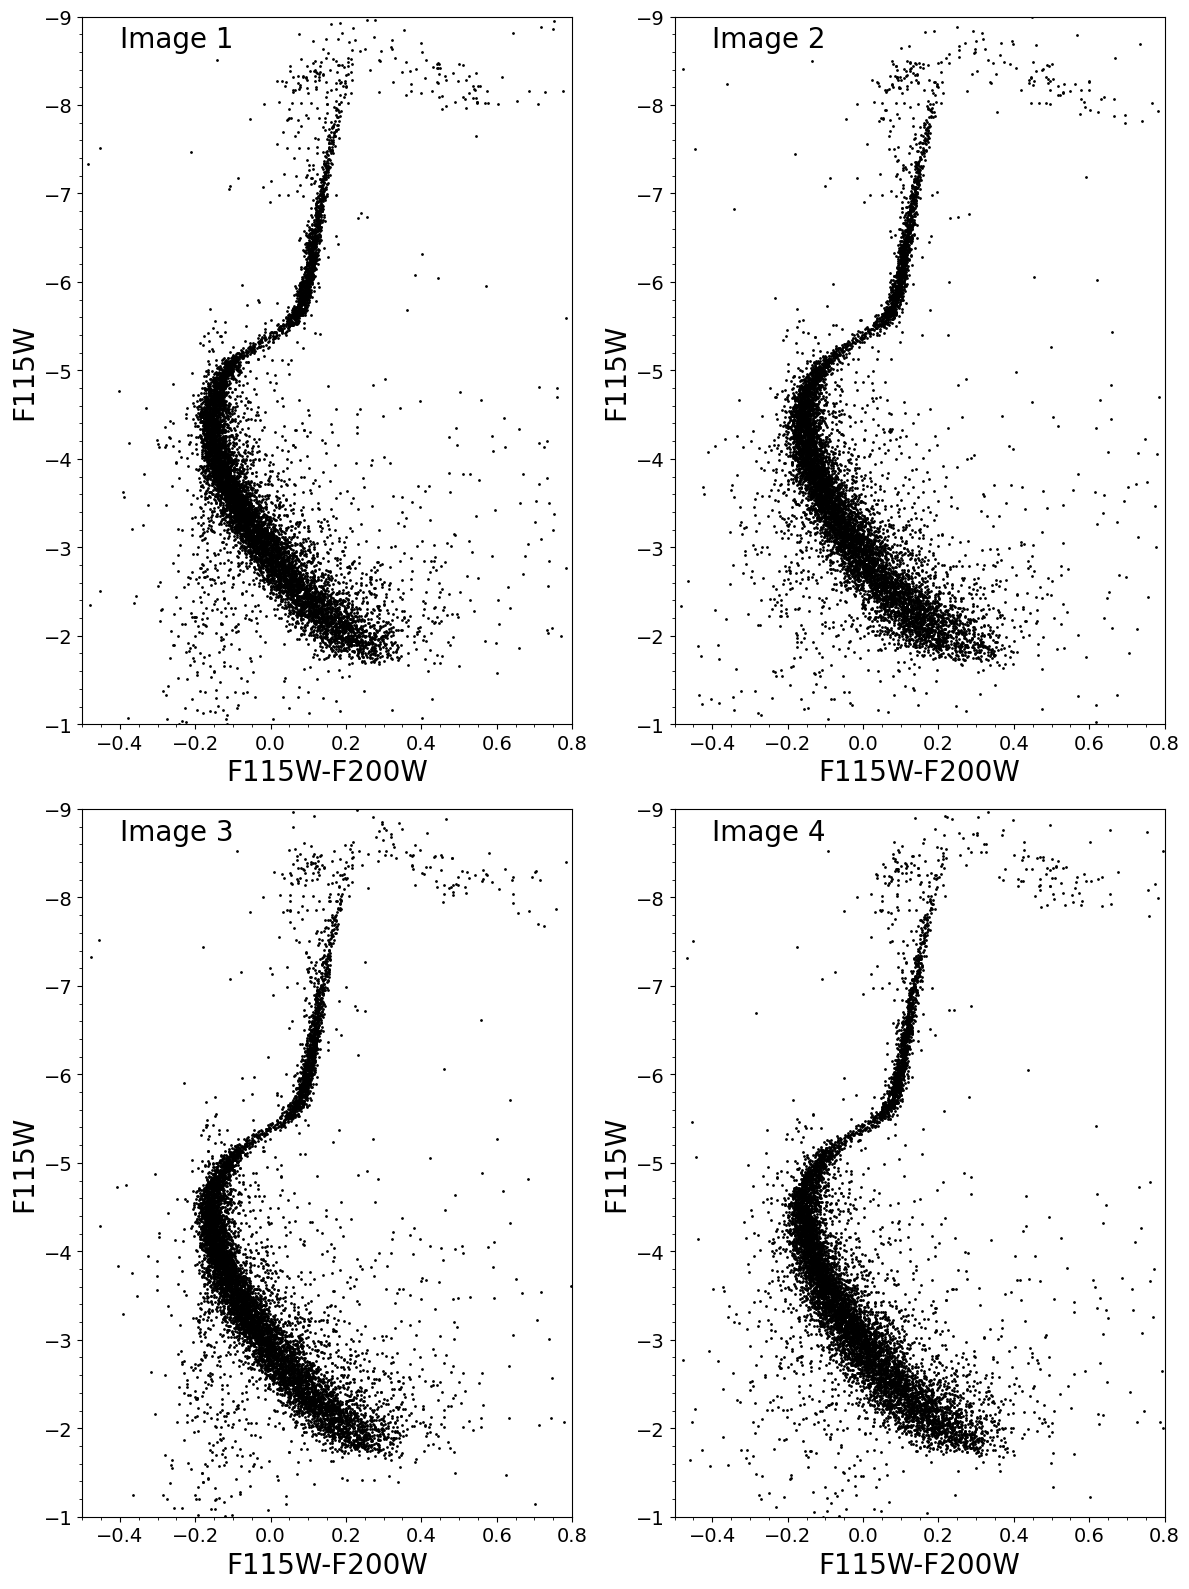

In [32]:
plt.figure(figsize=(12, 16))
plt.clf()

for i in np.arange(0, len(matches_phot_single), 1):
    ax = plt.subplot(2, 2, i + 1)

    j = str(i + 1)

    xlim0 = -0.5
    xlim1 = 0.8
    ylim0 = -1
    ylim1 = -9

    ax.set_xlim(xlim0, xlim1)
    ax.set_ylim(ylim0, ylim1)

    ax.xaxis.set_major_locator(ticker.AutoLocator())
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

    f115w_single = matches_phot_single[i]['mag_' + filt1]
    f200w_single = matches_phot_single[i]['mag_' + filt2]

    ax.scatter(f115w_single - f200w_single, f115w_single, s=1, color='k')

    ax.set_xlabel(filt1 + '-' + filt2, fontdict=font2)
    ax.set_ylabel(filt1, fontdict=font2)
    ax.text(xlim0 + 0.1, -8.65, f"Image {j}", fontdict=font2)
    
plt.tight_layout()

## Difference in retrieved positions (in pixels) between daofind an PSF routine

We show the difference in the stars position derived from daofind and the psf fitting algorithm. We also show the difference $\Delta$X and $\Delta$Y as a function of the instrumental magnitudes. 

2024-11-12 19:51:42,701 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,704 - stpipe - WARNING - findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.


2024-11-12 19:51:42,770 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,863 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,926 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:42,969 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,094 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,097 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,139 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,148 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,187 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


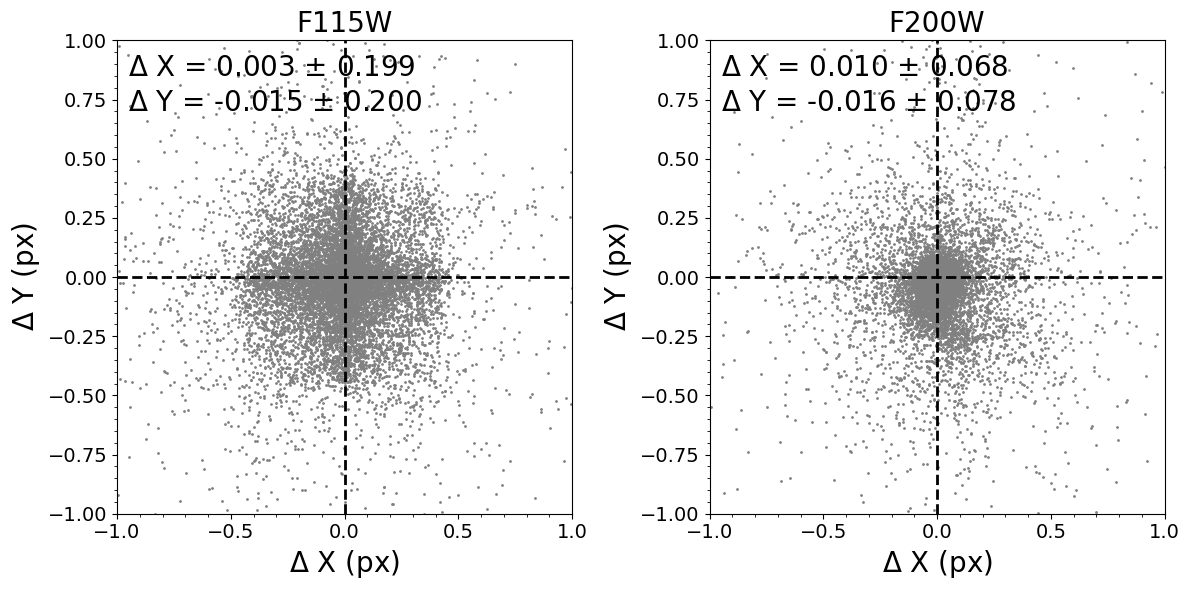

In [33]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)

xlim0 = -1
xlim1 = 1
ylim0 = -1
ylim1 = 1

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

x_find_f115w = results_clean_f115w[0]['x_0']
y_find_f115w = results_clean_f115w[0]['y_0']

x_psf_f115w = results_clean_f115w[0]['x_fit']
y_psf_f115w = results_clean_f115w[0]['y_fit']

delta_x_f115w = x_find_f115w - x_psf_f115w
delta_y_f115w = y_find_f115w - y_psf_f115w

_, d_x_f115w, sigma_d_x_f115w = sigma_clipped_stats(delta_x_f115w)
_, d_y_f115w, sigma_d_y_f115w = sigma_clipped_stats(delta_y_f115w)

ax1.scatter(delta_x_f115w, delta_y_f115w, s=1, color='gray')

ax1.set_xlabel(r'$\Delta$ X (px)', fontdict=font2)
ax1.set_ylabel(r'$\Delta$ Y (px)', fontdict=font2)
ax1.set_title(filt1, fontdict=font2)
ax1.text(xlim0 + 0.05, ylim1 - 0.15, rf'$\Delta$ X = {d_x_f115w:5.3f} $\pm$ {sigma_d_x_f115w:5.3f}',
         color='k', fontdict=font2)
ax1.text(xlim0 + 0.05, ylim1 - 0.30, rf'$\Delta$ Y = {d_y_f115w:5.3f} $\pm$ {sigma_d_y_f115w:5.3f}',
         color='k', fontdict=font2)
ax1.plot([0, 0], [ylim0, ylim1], color='k', lw=2, ls='--')
ax1.plot([xlim0, xlim1], [0, 0], color='k', lw=2, ls='--')

ax2 = plt.subplot(1, 2, 2)

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

x_find_f200w = results_clean_f200w[0]['x_0']
y_find_f200w = results_clean_f200w[0]['y_0']

x_psf_f200w = results_clean_f200w[0]['x_fit']
y_psf_f200w = results_clean_f200w[0]['y_fit']

delta_x_f200w = x_find_f200w - x_psf_f200w
delta_y_f200w = y_find_f200w - y_psf_f200w

_, d_x_f200w, sigma_d_x_f200w = sigma_clipped_stats(delta_x_f200w)
_, d_y_f200w, sigma_d_y_f200w = sigma_clipped_stats(delta_y_f200w)

ax2.scatter(delta_x_f200w, delta_y_f200w, s=1, color='gray')
ax2.text(xlim0 + 0.05, ylim1 - 0.15, rf'$\Delta$ X = {d_x_f200w:5.3f} $\pm$ {sigma_d_x_f200w:5.3f}',
         color='k', fontdict=font2)
ax2.text(xlim0 + 0.05, ylim1 - 0.30, rf'$\Delta$ Y = {d_y_f200w:5.3f} $\pm$ {sigma_d_y_f200w:5.3f}',
         color='k', fontdict=font2)
ax2.plot([0, 0], [ylim0, ylim1], color='k', lw=2, ls='--')
ax2.plot([xlim0, xlim1], [0, 0], color='k', lw=2, ls='--')

ax2.set_xlabel(r'$\Delta$ X (px)', fontdict=font2)
ax2.set_ylabel(r'$\Delta$ Y (px)', fontdict=font2)
ax2.set_title(filt2, fontdict=font2)

plt.tight_layout()

2024-11-12 19:51:43,304 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,304 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,386 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,488 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,536 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,585 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,633 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,833 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,834 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,835 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,870 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,905 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,906 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:43,940 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


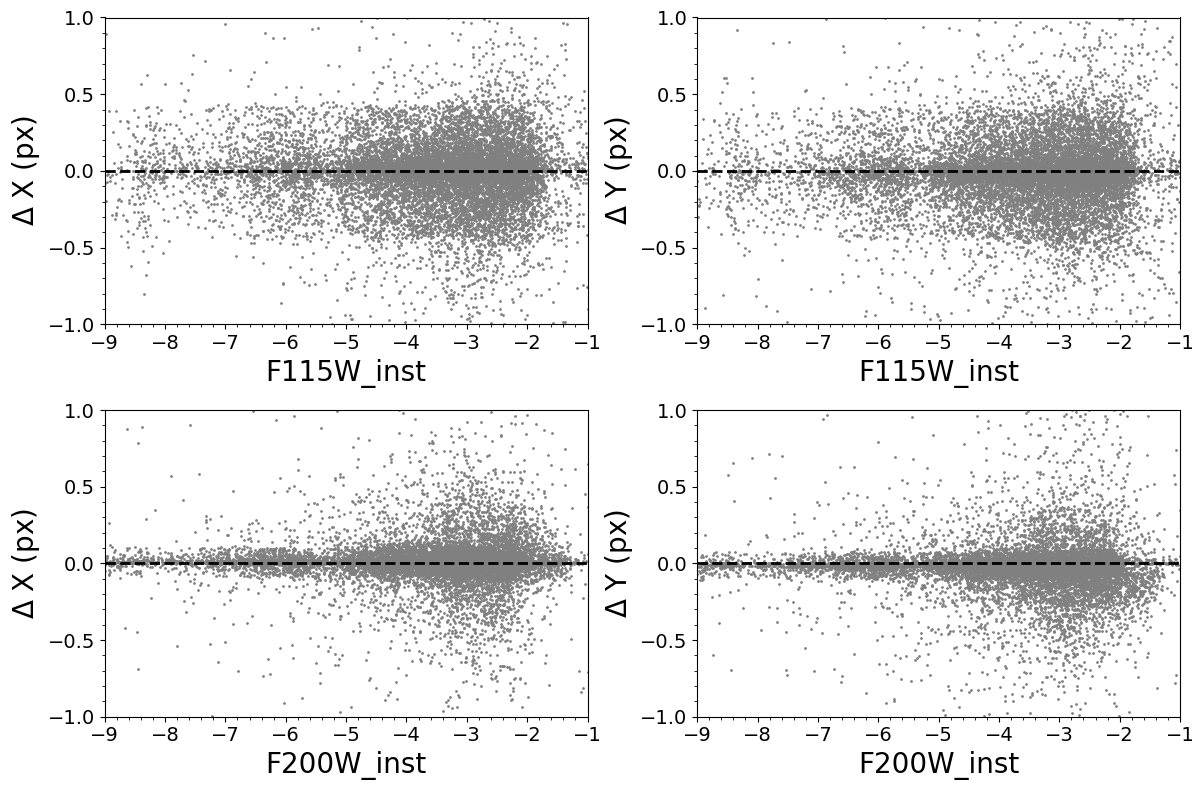

In [34]:
plt.figure(figsize=(12, 8))

ax1 = plt.subplot(2, 2, 1)

xlim0 = -9
xlim1 = -1
ylim0 = -1
ylim1 = 1

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

mag_inst_f115w = -2.5 * np.log10(results_clean_f115w[0]['flux_fit'])

ax1.scatter(mag_inst_f115w, delta_x_f115w, s=1, color='gray')
ax1.plot([xlim0, xlim1], [0, 0], color='k', lw=2, ls='--')

ax1.set_xlabel(filt1 + '_inst', fontdict=font2)
ax1.set_ylabel(r'$\Delta$ X (px)', fontdict=font2)

ax2 = plt.subplot(2, 2, 2)

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax2.scatter(mag_inst_f115w, delta_y_f115w, s=1, color='gray')
ax2.plot([xlim0, xlim1], [0, 0], color='k', lw=2, ls='--')

ax2.set_xlabel(filt1 + '_inst', fontdict=font2)
ax2.set_ylabel(r'$\Delta$ Y (px)', fontdict=font2)

ax3 = plt.subplot(2, 2, 3)

ax3.set_xlim(xlim0, xlim1)
ax3.set_ylim(ylim0, ylim1)

ax3.xaxis.set_major_locator(ticker.AutoLocator())
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax3.yaxis.set_major_locator(ticker.AutoLocator())
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator())

mag_inst_f200w = -2.5 * np.log10(results_clean_f200w[0]['flux_fit'])

ax3.scatter(mag_inst_f200w, delta_x_f200w, s=1, color='gray')
ax3.plot([xlim0, xlim1], [0, 0], color='k', lw=2, ls='--')

ax3.set_xlabel(filt2 + '_inst', fontdict=font2)
ax3.set_ylabel(r'$\Delta$ X (px)', fontdict=font2)

ax4 = plt.subplot(2, 2, 4)

ax4.set_xlim(xlim0, xlim1)
ax4.set_ylim(ylim0, ylim1)

ax4.xaxis.set_major_locator(ticker.AutoLocator())
ax4.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax4.yaxis.set_major_locator(ticker.AutoLocator())
ax4.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax4.scatter(mag_inst_f200w, delta_y_f200w, s=1, color='gray')
ax4.plot([xlim0, xlim1], [0, 0], color='k', lw=2, ls='--')

ax4.set_xlabel(filt2 + '_inst', fontdict=font2)
ax4.set_ylabel(r'$\Delta$ Y (px)', fontdict=font2)

plt.tight_layout()

## Cross-match the 4 catalogs for each filter

To obtain a final color-magnitude diagram, we need to cross-match all the catalogs for each filters and then cross-match the derived final catalogs.

**Note**: this is the most conservative approach since we impose that a star must be found in all 4 catalogs.

### Note for developer: 

I couldn't find an easier way to write this function, where you need to match the first two catalogs, derive a sub-catalogs with only the matches and then iterate for all the other catalogs available. We should also think on how to create a function that allows to keep the stars also if they are available in X out of Y catalogs (i.e., if for some reasons, a measure is not available in 1 of the images, but the star is well measured in the other 3, it doesn't make sense to discard the object).

In [35]:
def crossmatch_filter(table=None):

    num = 0
    num_cat = np.char.mod('%d', np.arange(1, len(table) + 1, 1))

    idx_12, d2d_12, _ = match_coordinates_sky(table[num]['radec'], table[num + 1]['radec'])

    sep_constraint_12 = d2d_12 < max_sep

    matches_12 = Table()

    matches_12['radec_' + num_cat[num]] = table[num]['radec'][sep_constraint_12]
    matches_12['mag_' + num_cat[num]] = (-2.5 * np.log10(table[num]['flux_fit']))[sep_constraint_12]
    matches_12['emag_' + num_cat[num]] = (1.086 * (table[num]['flux_unc'] / 
                                                   table[num]['flux_fit']))[sep_constraint_12]

    matches_12['radec_' + num_cat[num + 1]] = table[num + 1]['radec'][idx_12[sep_constraint_12]]
    matches_12['mag_' + num_cat[num + 1]] = (-2.5 * np.log10(table[num + 1]['flux_fit']))[idx_12[sep_constraint_12]]
    matches_12['emag_' + num_cat[num + 1]] = (1.086 * (table[num + 1]['flux_unc'] /
                                                       table[num + 1]['flux_fit']))[idx_12[sep_constraint_12]]

    idx_123, d2d_123, _ = match_coordinates_sky(matches_12['radec_' + num_cat[num]], table[num + 2]['radec'])

    sep_constraint_123 = d2d_123 < max_sep

    matches_123 = Table()

    matches_123['radec_' + num_cat[num]] = matches_12['radec_' + num_cat[num]][sep_constraint_123]
    matches_123['mag_' + num_cat[num]] = matches_12['mag_' + num_cat[num]][sep_constraint_123]
    matches_123['emag_' + num_cat[num]] = matches_12['emag_' + num_cat[num]][sep_constraint_123]
    matches_123['radec_' + num_cat[num + 1]] = matches_12['radec_' + num_cat[num + 1]][sep_constraint_123]
    matches_123['mag_' + num_cat[num + 1]] = matches_12['mag_' + num_cat[num + 1]][sep_constraint_123]
    matches_123['emag_' + num_cat[num + 1]] = matches_12['emag_' + num_cat[num + 1]][sep_constraint_123]
    matches_123['radec_' + num_cat[num + 2]] = table[num + 2]['radec'][idx_123[sep_constraint_123]]
    matches_123['mag_' + num_cat[num + 2]] = (-2.5 * np.log10(table[num + 2]['flux_fit']))[idx_123[sep_constraint_123]]
    matches_123['emag_' + num_cat[num + 2]] = (1.086 * (table[num + 2]['flux_unc'] /
                                                        table[num + 2]['flux_fit']))[idx_123[sep_constraint_123]]

    idx_1234, d2d_1234, _ = match_coordinates_sky(matches_123['radec_' + num_cat[num]], table[num + 3]['radec'])

    sep_constraint_1234 = d2d_1234 < max_sep

    matches_1234 = Table()

    matches_1234['radec_' + num_cat[num]] = matches_123['radec_' + num_cat[num]][sep_constraint_1234]
    matches_1234['mag_' + num_cat[num]] = matches_123['mag_' + num_cat[num]][sep_constraint_1234]
    matches_1234['emag_' + num_cat[num]] = matches_123['emag_' + num_cat[num]][sep_constraint_1234]
    matches_1234['radec_' + num_cat[num + 1]] = matches_123['radec_' + num_cat[num + 1]][sep_constraint_1234]
    matches_1234['mag_' + num_cat[num + 1]] = matches_123['mag_' + num_cat[num + 1]][sep_constraint_1234]
    matches_1234['emag_' + num_cat[num + 1]] = matches_123['emag_' + num_cat[num + 1]][sep_constraint_1234]
    matches_1234['radec_' + num_cat[num + 2]] = matches_123['radec_' + num_cat[num + 2]][sep_constraint_1234]
    matches_1234['mag_' + num_cat[num + 2]] = matches_123['mag_' + num_cat[num + 2]][sep_constraint_1234]
    matches_1234['emag_' + num_cat[num + 2]] = matches_123['emag_' + num_cat[num + 2]][sep_constraint_1234]
    matches_1234['radec_' + num_cat[num + 3]] = table[num + 3]['radec'][idx_1234[sep_constraint_1234]]
    matches_1234['mag_' + num_cat[num + 3]] = (-2.5 * np.log10(table[num + 3]['flux_fit']))[idx_1234[sep_constraint_1234]]
    matches_1234['emag_' + num_cat[num + 3]] = (1.086 * (table[num + 3]['flux_unc'] /
                                                         table[num + 3]['flux_fit']))[idx_1234[sep_constraint_1234]]

    matches_1234

    return matches_1234

In [36]:
matches_f115w = crossmatch_filter(table=results_clean_f115w)
matches_f200w = crossmatch_filter(table=results_clean_f200w)

For the final catalog, we assume that the magnitude is the mean of the 4 measures and the error on the magnitude is its standard deviation.

To easily perform this arithmetic operation on the table, we convert the table to pandas dataframe.

In [37]:
df_f115w = matches_f115w.to_pandas()
df_f200w = matches_f200w.to_pandas()

df_f115w['RA_' + filt1] = df_f115w[['radec_1.ra', 'radec_2.ra', 'radec_3.ra', 'radec_4.ra']].mean(axis=1)
df_f115w['e_RA_' + filt1] = df_f115w[['radec_1.ra', 'radec_2.ra', 'radec_3.ra', 'radec_4.ra']].std(axis=1)
df_f115w['Dec_' + filt1] = df_f115w[['radec_1.dec', 'radec_2.dec', 'radec_3.dec', 'radec_4.dec']].mean(axis=1)
df_f115w['e_Dec_' + filt1] = df_f115w[['radec_1.dec', 'radec_2.dec', 'radec_3.dec', 'radec_4.dec']].std(axis=1)
df_f115w[filt1 + '_inst'] = df_f115w[['mag_1', 'mag_2', 'mag_3', 'mag_4']].mean(axis=1)
df_f115w['e' + filt1 + '_inst'] = df_f115w[['mag_1', 'mag_2', 'mag_3', 'mag_4']].std(axis=1)

df_f200w['RA_' + filt2] = df_f200w[['radec_1.ra', 'radec_2.ra', 'radec_3.ra', 'radec_4.ra']].mean(axis=1)
df_f200w['e_RA_' + filt2] = df_f200w[['radec_1.ra', 'radec_2.ra', 'radec_3.ra', 'radec_4.ra']].std(axis=1)
df_f200w['Dec_' + filt2] = df_f200w[['radec_1.dec', 'radec_2.dec', 'radec_3.dec', 'radec_4.dec']].mean(axis=1)
df_f200w['e_Dec_' + filt2] = df_f200w[['radec_1.dec', 'radec_2.dec', 'radec_3.dec', 'radec_4.dec']].std(axis=1)
df_f200w[filt2 + '_inst'] = df_f200w[['mag_1', 'mag_2', 'mag_3', 'mag_4']].mean(axis=1)
df_f200w['e' + filt2 + '_inst'] = df_f200w[['mag_1', 'mag_2', 'mag_3', 'mag_4']].std(axis=1)

## Final Color-Magnitude Diagram (Instrumental Magnitudes)

2024-11-12 19:51:44,269 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,270 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,318 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,403 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,459 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,474 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,511 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,557 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,717 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,718 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,719 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,734 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,735 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,757 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,790 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:44,791 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


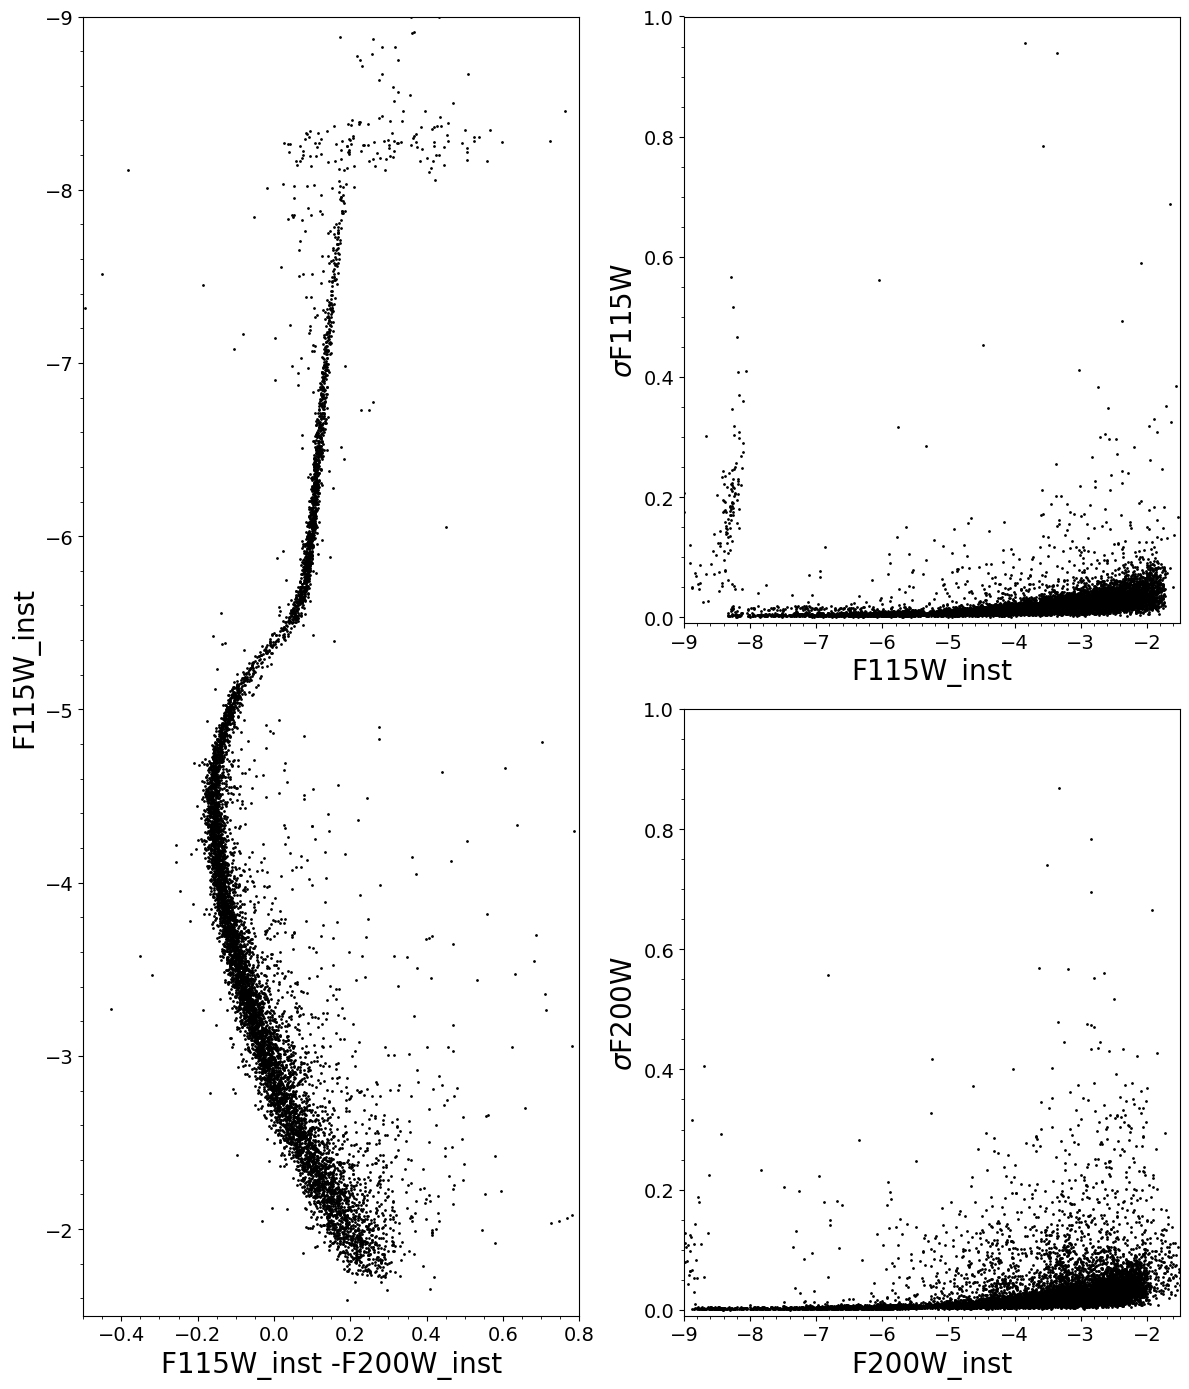

In [38]:
plt.figure(figsize=(12, 14))
plt.clf()

ax1 = plt.subplot(1, 2, 1)

ax1.set_xlabel(filt1 + '_inst -' + filt2 + '_inst', fontdict=font2)
ax1.set_ylabel(filt1 + '_inst', fontdict=font2)

xlim0 = -0.5
xlim1 = 0.8
ylim0 = -1.5
ylim1 = -9

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

radec_f115w_inst = SkyCoord(df_f115w['RA_' + filt1], df_f115w['Dec_' + filt1], unit='deg')
radec_f200w_inst = SkyCoord(df_f200w['RA_' + filt2], df_f200w['Dec_' + filt2], unit='deg')

idx_inst, d2d_inst, _ = match_coordinates_sky(radec_f115w_inst, radec_f200w_inst)

sep_constraint_inst = d2d_inst < max_sep

f115w_inst = np.array(df_f115w[filt1 + '_inst'][sep_constraint_inst])
ef115w_inst = np.array(df_f115w['e' + filt1 + '_inst'][sep_constraint_inst])
radec_f115w = radec_f115w_inst[sep_constraint_inst]

f200w_inst = np.array(df_f200w[filt2 + '_inst'][idx_inst[sep_constraint_inst]])
ef200w_inst = np.array(df_f200w['e' + filt2 + '_inst'][idx_inst[sep_constraint_inst]])
radec_f200w = radec_f200w_inst[idx_inst[sep_constraint_inst]]

ax1.scatter(f115w_inst - f200w_inst, f115w_inst, s=1, color='k')

ax2 = plt.subplot(2, 2, 2)

ax2.set_xlabel(filt1 + '_inst', fontdict=font2)
ax2.set_ylabel(r'$\sigma$' + filt1, fontdict=font2)

xlim0 = -9
xlim1 = -1.5
ylim0 = -0.01 
ylim1 = 1

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax2.scatter(df_f115w[filt1 + '_inst'], df_f115w['e' + filt1 + '_inst'], s=1, color='k')

ax3 = plt.subplot(2, 2, 4)

ax3.set_xlabel(filt2 + '_inst', fontdict=font2)
ax3.set_ylabel(r'$\sigma$' + filt2, fontdict=font2)

ax3.set_xlim(xlim0, xlim1)
ax3.set_ylim(ylim0, ylim1)

ax3.xaxis.set_major_locator(ticker.AutoLocator())
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax3.yaxis.set_major_locator(ticker.AutoLocator())
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax3.scatter(df_f200w[filt2 + '_inst'], df_f200w['e' + filt2 + '_inst'], s=1, color='k')

plt.tight_layout()

## Photometric Zeropoints

To obtain the final calibrated color-magnitude diagram, we need to calculate the photometric zeropoints. Hence we need to perform aperture photometry on the calibrated images (Level-3), apply the appropriate aperture correction for the finite aperture adopted (the values provided in the dictionary above are for an infinite aperture) and then compare it with the PSF photometry. Hence, we can summarize the steps as follows:

* perform aperture photometry 
* apply appropriate aperture correction
* apply tabulated zeropoint
* cross-match with psf photometry

## Load the calibrated and rectified images (Level 3 imaging pipeline)

In [39]:
dict_images_combined = {'NRCA1': {}, 'NRCA2': {}, 'NRCA3': {}, 'NRCA4': {}, 'NRCA5': {},
                        'NRCB1': {}, 'NRCB2': {}, 'NRCB3': {}, 'NRCB4': {}, 'NRCB5': {}}

dict_filter_short = {}
dict_filter_long = {}

ff_short = []
det_short = []
det_long = []
ff_long = []
detlist_short = []
detlist_long = []
filtlist_short = []
filtlist_long = []

if not glob.glob('./*combined*fits'):

    print("Downloading images")

    boxlink_images_lev3 = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/stellar_photometry/images_level3.tar.gz'
    boxfile_images_lev3 = './images_level3.tar.gz'
    request.urlretrieve(boxlink_images_lev3, boxfile_images_lev3)

    tar = tarfile.open(boxfile_images_lev3, 'r')
    tar.extractall(filter='data')

    images_dir = './'
    files_singles = sorted(glob.glob(os.path.join(images_dir, "*combined*fits")))

else:

    images_dir = './'
    files_singles = sorted(glob.glob(os.path.join(images_dir, "*combined*fits")))

for file in files_singles:

    im = fits.open(file)
    f = im[0].header['FILTER']
    d = im[0].header['DETECTOR']

    if d == 'NRCBLONG':
        d = 'NRCB5'
    elif d == 'NRCALONG':
        d = 'NRCA5'
    else:
        d = d

    wv = float(f[1:3])

    if wv > 24:
        ff_long.append(f)
        det_long.append(d)

    else:
        ff_short.append(f)
        det_short.append(d)

    detlist_short = sorted(list(dict.fromkeys(det_short)))
    detlist_long = sorted(list(dict.fromkeys(det_long)))

    unique_list_filters_short = []
    unique_list_filters_long = []

    for x in ff_short:

        if x not in unique_list_filters_short:

            dict_filter_short.setdefault(x, {})

    for x in ff_long:
        if x not in unique_list_filters_long:
            dict_filter_long.setdefault(x, {})

    for d_s in detlist_short:
        dict_images_combined[d_s] = dict_filter_short

    for d_l in detlist_long:
        dict_images_combined[d_l] = dict_filter_long

    filtlist_short = sorted(list(dict.fromkeys(dict_filter_short)))
    filtlist_long = sorted(list(dict.fromkeys(dict_filter_long)))

    if len(dict_images_combined[d][f]) == 0:
        dict_images_combined[d][f] = {'images': [file]}
    else:
        dict_images_combined[d][f]['images'].append(file)

print("Available Detectors for SW channel:", detlist_short)
print("Available Detectors for LW channel:", detlist_long)
print("Available SW Filters:", filtlist_short)
print("Available LW Filters:", filtlist_long)

Available Detectors for SW channel: ['NRCB1']
Available Detectors for LW channel: ['NRCB5']
Available SW Filters: ['F070W', 'F115W', 'F200W']
Available LW Filters: ['F277W', 'F356W', 'F444W']


##  Display the images

2024-11-12 19:51:51,899 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:51,901 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,137 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,142 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,168 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,266 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,275 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,277 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,368 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,377 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,379 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,601 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,602 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,603 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,686 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,687 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,696 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,698 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,703 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,786 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,795 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:52,797 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


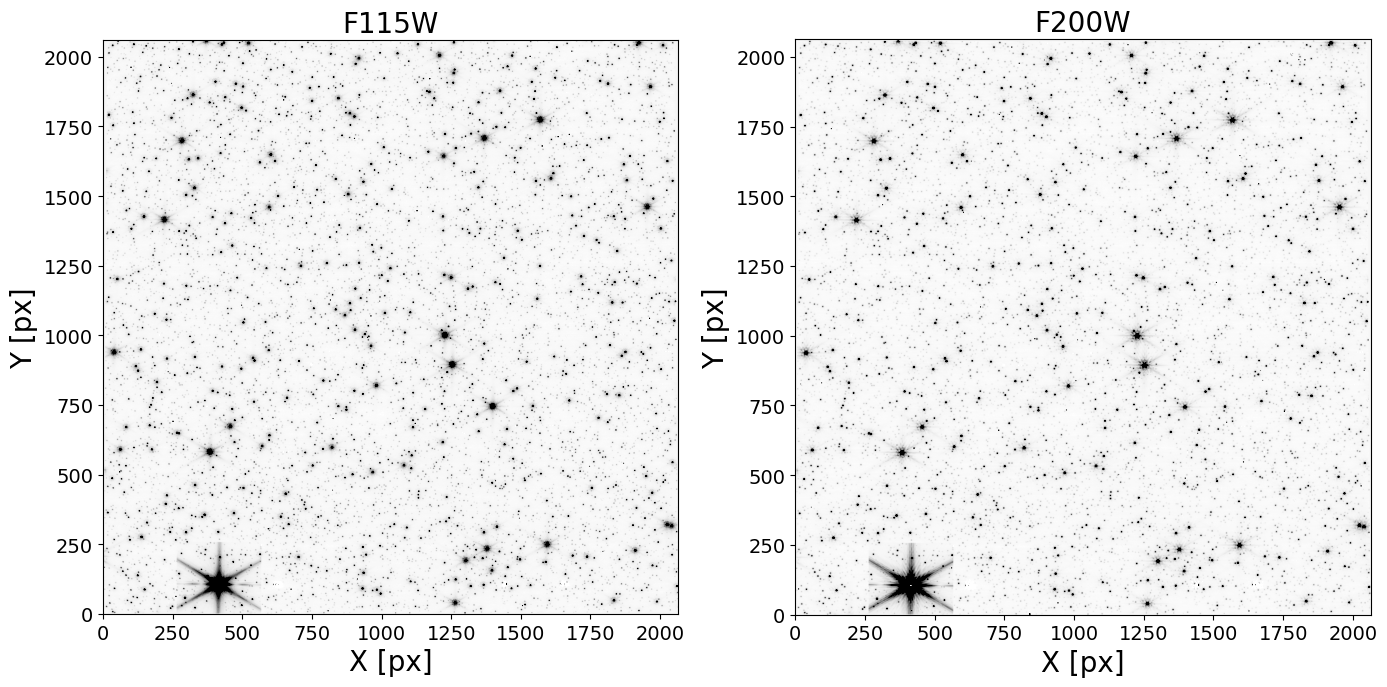

In [40]:
plt.figure(figsize=(14, 14))

for det in dets_short:
    for i, filt in enumerate(filts_short):

        image = fits.open(dict_images_combined[det][filt]['images'][0])
        data_sb = image[1].data

        ax = plt.subplot(1, len(filts_short), i + 1)

        norm = simple_norm(data_sb, 'sqrt', percent=99.)
        plt.xlabel("X [px]", fontdict=font2)
        plt.ylabel("Y [px]", fontdict=font2)
        plt.title(filt, fontdict=font2)

        ax.imshow(data_sb, norm=norm, cmap='Greys')
plt.tight_layout()

## Aperture Photometry

As we have done previously, we create a dictionary that contains the tables with the derived aperture photometry for each image.

In [41]:
dict_aper = {}

for det in dets_short:

    dict_aper.setdefault(det, {})
    for j, filt in enumerate(filts_short):

        dict_aper[det].setdefault(filt, {})

        dict_aper[det][filt]['stars for ap phot'] = None
        dict_aper[det][filt]['stars for ap phot matched'] = None
        dict_aper[det][filt]['aperture phot table'] = None

### Find bright isolated stars

In [42]:
def find_bright_stars(det='NRCA1', filt='F070W', dist_sel=False):

    bkgrms = MADStdBackgroundRMS()
    mmm_bkg = MMMBackground()

    image = fits.open(dict_images_combined[det][filt]['images'][i])
    data_sb = image[1].data
    imh = image[1].header

    print(f"Selecting stars for aperture photometry on image {i + 1} of filter {filt}, detector {det}")

    data = data_sb / imh['PHOTMJSR']
    units = imh['BUNIT']
    print(f"Conversion factor from {units} to DN/s for filter {filt}: {imh['PHOTMJSR']}")

    sigma_psf = dict_utils[filt]['psf fwhm']

    print(f"FWHM for the filter {filt}: {sigma_psf} px")

    std = bkgrms(data)
    bkg = mmm_bkg(data)
    daofind = DAOStarFinder(threshold=th[j] * std + bkg, fwhm=sigma_psf, roundhi=1.0, roundlo=-1.0,
                            sharplo=0.30, sharphi=1.40)

    apcorr_stars = daofind(data)
    dict_aper[det][filt]['stars for ap phot'] = apcorr_stars
    
    if dist_sel:

        print("")
        print("Calculating closest neigbhour distance")

        d = []

        daofind_tot = DAOStarFinder(threshold=10 * std + bkg, fwhm=sigma_psf, roundhi=1.0, roundlo=-1.0,
                                    sharplo=0.30, sharphi=1.40)

        stars_tot = daofind_tot(data)

        x_tot = stars_tot['xcentroid']
        y_tot = stars_tot['ycentroid']

        for xx, yy in zip(apcorr_stars['xcentroid'], apcorr_stars['ycentroid']):

            sep = []
            dist = np.sqrt((x_tot - xx)**2 + (y_tot - yy)**2)
            sep = np.sort(dist)[1:2][0]
            d.append(sep)

        apcorr_stars['min distance'] = d
        mask_dist = (apcorr_stars['min distance'] > min_sep[j])

        apcorr_stars = apcorr_stars[mask_dist]

        dict_aper[det][filt]['stars for ap phot'] = apcorr_stars

        print("Minimum distance required:", min_sep[j], "px")
        print("")
        print(f"Number of bright isolated sources found in the image for {filt}: {len(apcorr_stars)}")
        print("-----------------------------------------------------")
        print("")
    else:
        print("")
        print(f"Number of bright sources found in the image for {filt}: {len(apcorr_stars)}")
        print("--------------------------------------------")
        print("")    
    
    return

In [43]:
tic = time.perf_counter()

th = [700, 500]  # threshold level for the two filters (length must match number of filters analyzed)
min_sep = [10, 10]  # minimum separation acceptable for zp stars from closest neighbour


for det in dets_short:
    for j, filt in enumerate(filts_short):
        for i in np.arange(0, len(dict_images_combined[det][filt]['images']), 1):

            find_bright_stars(det=det, filt=filt, dist_sel=False)

toc = time.perf_counter()

print("Elapsed Time for finding stars for Aperture Photometry:", toc - tic)            

Selecting stars for aperture photometry on image 1 of filter F115W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
FWHM for the filter F115W: 1.298 px



Number of bright sources found in the image for F115W: 1302
--------------------------------------------

Selecting stars for aperture photometry on image 1 of filter F200W, detector NRCB1
Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
FWHM for the filter F200W: 2.141 px



Number of bright sources found in the image for F200W: 1483
--------------------------------------------

Elapsed Time for finding stars for Aperture Photometry: 2.465831081000033


As a further way to obtain a good quality sample, we cross-match the catalogs from the two filters and retain only the stars in common

In [44]:
for det in dets_short:
    for j, filt in enumerate(filts_short):
        for i in np.arange(0, len(dict_images_combined[det][filt]['images']), 1):

            image = ImageModel(dict_images_combined[det][filt]['images'][i])

            ra, dec = image.meta.wcs(dict_aper[det][filt]['stars for ap phot']['xcentroid'],
                                     dict_aper[det][filt]['stars for ap phot']['ycentroid'])
        
            radec = SkyCoord(ra, dec, unit='deg')
            dict_aper[det][filt]['stars for ap phot']['radec'] = radec

In [45]:
idx_ap, d2d_ap, _ = match_coordinates_sky(dict_aper[det][filt1]['stars for ap phot']['radec'],
                                          dict_aper[det][filt2]['stars for ap phot']['radec'])

sep_constraint_ap = d2d_ap < max_sep

matched_apcorr_f115w = Table()
matched_apcorr_f200w = Table()

matched_apcorr_f115w = dict_aper[det][filt1]['stars for ap phot'][sep_constraint_ap]
matched_apcorr_f200w = dict_aper[det][filt2]['stars for ap phot'][idx_ap[sep_constraint_ap]]

dict_aper[det][filt1]['stars for ap phot matched'] = matched_apcorr_f115w
dict_aper[det][filt2]['stars for ap phot matched'] = matched_apcorr_f200w

### Load aperture correction table

**Note**: these values are obtained from the study of the synthetic WebbPSF PSFs. They will be updated once we have in-flight measures.

In [46]:
if os.path.isfile('./aperture_correction_table.txt'):
    ap_tab = './aperture_correction_table.txt'
else:
    print("Downloading the aperture correction table")

    boxlink_apcorr_table = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/stellar_photometry/aperture_correction_table.txt'
    boxfile_apcorr_table = './aperture_correction_table.txt'
    request.urlretrieve(boxlink_apcorr_table, boxfile_apcorr_table)
    ap_tab = './aperture_correction_table.txt'

aper_table = pd.read_csv(ap_tab, header=None, sep=r'\s+', index_col=0,
                         names=['filter', 'pupil', 'wave', 'r10', 'r20', 'r30', 'r40', 'r50', 'r60', 'r70', 'r80',
                                'r85', 'r90', 'sky_flux_px', 'apcorr10', 'apcorr20', 'apcorr30', 'apcorr40',
                                'apcorr50', 'apcorr60', 'apcorr70', 'apcorr80', 'apcorr85', 'apcorr90', 'sky_in',
                                'sky_out'], comment='#', skiprows=0, usecols=range(0, 26))
aper_table.head()

pupil  wave    r10    r20    r30    r40    r50    r60    r70    r80  \
filter                                                                        
F070W   CLEAR    70  0.451  0.869  1.263  1.648  2.191  3.266  5.176  7.292   
F090W   CLEAR    90  0.408  0.638  0.992  1.503  1.925  2.549  4.162  7.480   
F115W   CLEAR   115  0.374  0.571  0.778  1.036  1.768  2.324  3.287  6.829   
F140M   CLEAR   140  0.414  0.617  0.801  1.031  1.367  2.434  3.118  6.031   
F150W   CLEAR   150  0.431  0.639  0.826  1.065  1.360  2.476  3.199  6.082   

        ...  apcorr30  apcorr40  apcorr50  apcorr60  apcorr70  apcorr80  \
filter  ...                                                               
F070W   ...    3.3651    2.5305    2.0347    1.7210    1.5328    1.4174   
F090W   ...    3.3519    2.5241    2.0253    1.6977    1.4908    1.4173   
F115W   ...    3.3404    2.5070    2.0131    1.6825    1.4520    1.3310   
F140M   ...    3.3397    2.5060    2.0067    1.6815    1.4465    1.3029   
F150W   ...    3.3405    2.5067    2.0070    1.6828    1.4485    1.3068   

        apcorr85  apcorr90  sky_in  sky_out  
filter                                       
F070W     1.4174    1.5880   7.292    9.017  
F090W     1.4173    1.6016   7.480    9.251  
F115W     1.3310    1.3964   6.829    9.723  
F140M     1.3029    1.3794   6.031    9.608  
F150W     1.3068    1.4188   6.082    9.496  

[5 rows x 25 columns]

### Perform Aperture Photometry

In [47]:
def aperture_phot(det=det, filt='F070W'):

    radii = [aper_table.loc[filt]['r70']]

    ees = '70'.split()
    ee_radii = dict(zip(ees, radii))

    positions = np.transpose((dict_aper[det][filt]['stars for ap phot matched']['xcentroid'],
                              dict_aper[det][filt]['stars for ap phot matched']['ycentroid']))

    image = fits.open(dict_images_combined[det][filt]['images'][0])
    data_sb = image[1].data
    imh = image[1].header
    data = data_sb / imh['PHOTMJSR']

    # sky from the aperture correction table:

    sky = {"sky_in": aper_table.loc[filt]['r80'], "sky_out": aper_table.loc[filt]['r85']}

    tic = time.perf_counter()

    table_aper = Table()

    for ee, radius in ee_radii.items():
        print(f"Performing aperture photometry for radius equivalent to EE = {ee}% for filter {filt}")
        aperture = CircularAperture(positions, r=radius)
        annulus_aperture = CircularAnnulus(positions, r_in=sky["sky_in"], r_out=sky["sky_out"])
        annulus_mask = annulus_aperture.to_mask(method='center')

        bkg_median = []
        for mask in annulus_mask:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_sigclip)
        bkg_median = np.array(bkg_median)

        phot = aperture_photometry(data, aperture, method='exact')
        phot['annulus_median'] = bkg_median
        phot['aper_bkg'] = bkg_median * aperture.area
        phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

        apcorr = [aper_table.loc[filt]['apcorr70']]

        phot['aper_sum_corrected'] = phot['aper_sum_bkgsub'] * apcorr

        phot['mag_corrected'] = -2.5 * np.log10(phot['aper_sum_corrected']) + dict_utils[filt]['VegaMAG zp modB']

        table_aper.add_column(phot['aperture_sum'], name='aper_sum_' + ee)
        table_aper.add_column(phot['annulus_median'], name='annulus_median_' + ee)
        table_aper.add_column(phot['aper_bkg'], name='aper_bkg_ee_' + ee)
        table_aper.add_column(phot['aper_sum_bkgsub'], name='aper_sum_bkgsub_' + ee)
        table_aper.add_column(phot['aper_sum_corrected'], name='aper_sum_corrected_' + filt) 
        table_aper.add_column(phot['mag_corrected'], name='mag_corrected_' + filt)

        dict_aper[det][filt]['aperture phot table'] = table_aper

    toc = time.perf_counter()
    print("Time Elapsed:", toc - tic)

    return

In [48]:
aperture_phot(det=det, filt=filt1)
aperture_phot(det=det, filt=filt2)

Performing aperture photometry for radius equivalent to EE = 70% for filter F115W


Time Elapsed: 0.4036974729999656
Performing aperture photometry for radius equivalent to EE = 70% for filter F200W


Time Elapsed: 0.34619846900000084


### Derive Zeropoints

2024-11-12 19:51:58,272 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,273 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,299 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,355 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,419 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,429 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,450 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,460 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,566 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,567 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,568 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,579 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,580 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,604 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,605 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:51:58,615 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


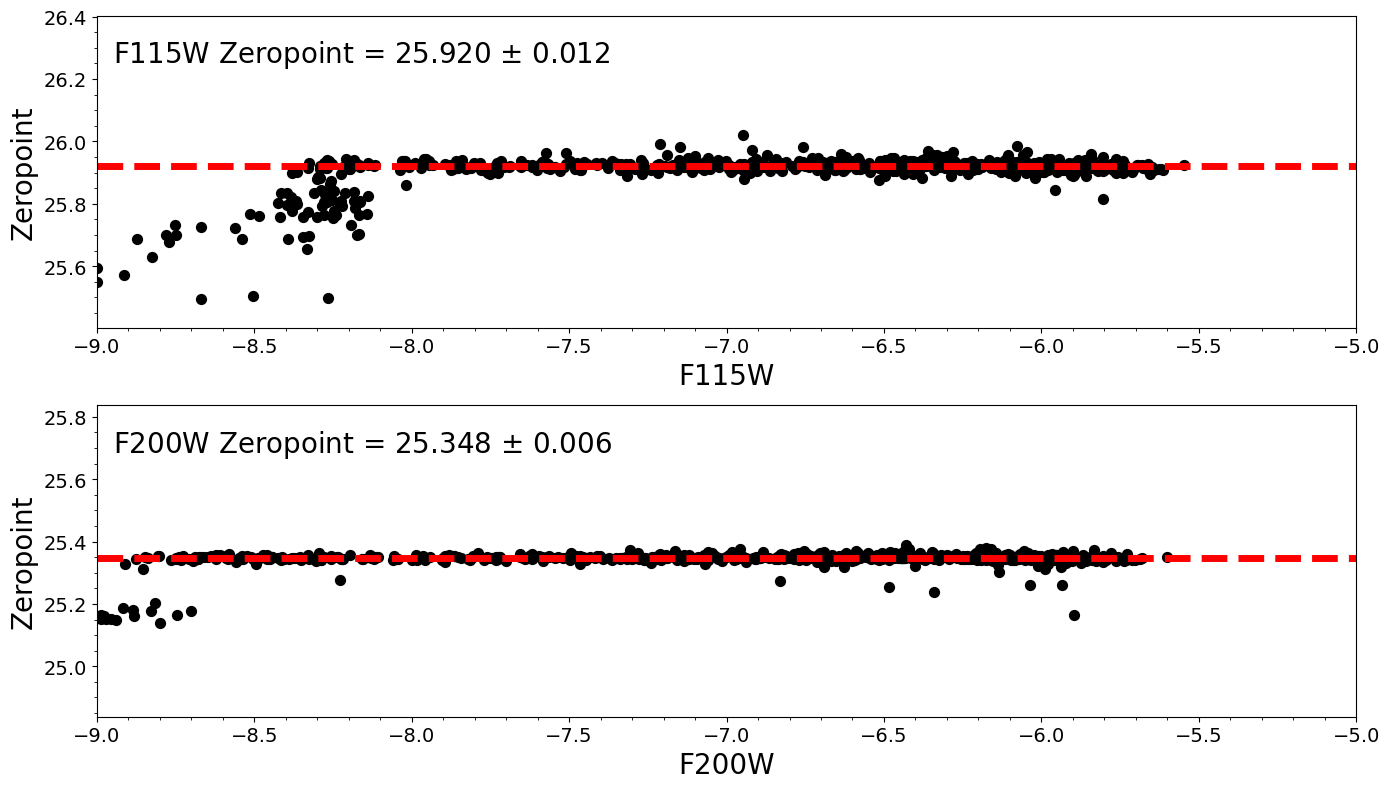

In [49]:
plt.figure(figsize=(14, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel(filt1, fontdict=font2)
ax1.set_ylabel('Zeropoint', fontdict=font2)

idx_zp_1, d2d_zp_1, _ = match_coordinates_sky(dict_aper[det][filt1]['stars for ap phot matched']['radec'], radec_f115w_inst)

sep_constraint_zp_1 = d2d_zp_1 < max_sep

f115w_ap_matched = np.array(dict_aper[det][filt1]['aperture phot table']['mag_corrected_' + filt1][sep_constraint_zp_1])
f115w_psf_matched = np.array(df_f115w[filt1 + '_inst'][idx_zp_1[sep_constraint_zp_1]])

diff_f115w = f115w_ap_matched - f115w_psf_matched
_, zp_f115w, zp_sigma_f115w = sigma_clipped_stats(diff_f115w)

xlim0 = -9
xlim1 = -5
ylim0 = np.mean(diff_f115w) - 0.5
ylim1 = np.mean(diff_f115w) + 0.5

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(f115w_psf_matched, diff_f115w, s=50, color='k')
ax1.plot([xlim0, xlim1], [zp_f115w, zp_f115w], color='r', lw=5, ls='--')
ax1.text(xlim0 + 0.05, ylim1 - 0.15, filt1 + rf' Zeropoint = {zp_f115w:5.3f} $\pm$ {zp_sigma_f115w:5.3f}', color='k', fontdict=font2)
                
ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel(filt2, fontdict=font2)
ax2.set_ylabel('Zeropoint', fontdict=font2)

idx_zp_2, d2d_zp_2, _ = match_coordinates_sky(dict_aper[det][filt2]['stars for ap phot matched']['radec'], radec_f200w_inst)

sep_constraint_zp_2 = d2d_zp_2 < max_sep

f200w_ap_matched = np.array(dict_aper[det][filt2]['aperture phot table']['mag_corrected_' + filt2][sep_constraint_zp_2])
f200w_psf_matched = np.array(df_f200w[filt2 + '_inst'][idx_zp_2[sep_constraint_zp_2]])

diff_f200w = f200w_ap_matched - f200w_psf_matched
_, zp_f200w, zp_sigma_f200w = sigma_clipped_stats(diff_f200w)

xlim0 = -9
xlim1 = -5
ylim0 = np.mean(diff_f200w) - 0.5
ylim1 = np.mean(diff_f200w) + 0.5

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax2.scatter(f200w_psf_matched, diff_f200w, s=50, color='k')
ax2.plot([xlim0, xlim1], [zp_f200w, zp_f200w], color='r', lw=5, ls='--')
ax2.text(xlim0 + 0.05, ylim1 - 0.15, filt2 + rf' Zeropoint = {zp_f200w:5.3f} $\pm$ {zp_sigma_f200w:5.3f}', color='k', fontdict=font2)
                
plt.tight_layout()

## Import input photometry

In [50]:
if os.path.isfile('./pointsource.cat'):
    input_cat = './pointsource.cat'

else:
    
    print("Downloading input pointsource catalog")

    boxlink_input_cat = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/stellar_photometry/pointsource.cat'
    boxfile_input_cat = './pointsource.cat'
    request.urlretrieve(boxlink_input_cat, boxfile_input_cat)
    input_cat = './pointsource.cat'

cat = pd.read_csv(input_cat, header=None, sep=r'\s+', names=['ra_in', 'dec_in', 'f070w_in', 'f115w_in',
                                                             'f200w_in', 'f277w_in', 'f356w_in', 'f444w_in'],
                  comment='#', skiprows=7, usecols=range(0, 8))

cat.head()

ra_in     dec_in  f070w_in  f115w_in  f200w_in  f277w_in  f356w_in  \
0  80.386396 -69.468909  21.34469  20.75333  20.25038  20.23116  20.20482   
1  80.385588 -69.469201  20.12613  19.33709  18.64676  18.63521  18.58796   
2  80.380365 -69.470930  21.52160  20.98518  20.53500  20.51410  20.49231   
3  80.388130 -69.468453  20.82162  20.06542  19.40552  19.39262  19.34927   
4  80.388936 -69.468196  21.47197  20.92519  20.46507  20.44447  20.42186   

   f444w_in  
0  20.23520  
1  18.64291  
2  20.51610  
3  19.40018  
4  20.44687

Extract from the input catalog the stars in the same region as the one analyzed

In [51]:
lim_ra_min = np.min(radec_f115w.ra)
lim_ra_max = np.max(radec_f115w.ra)
lim_dec_min = np.min(radec_f115w.dec)
lim_dec_max = np.max(radec_f115w.dec)

cat_sel = cat[(cat['ra_in'] > lim_ra_min) & (cat['ra_in'] < lim_ra_max) & (cat['dec_in'] > lim_dec_min)
              & (cat['dec_in'] < lim_dec_max)]

## Calibrated Color-Magnitude Diagram

2024-11-12 19:52:01,471 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,472 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,499 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,500 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,559 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,614 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,625 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,627 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,661 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,671 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,673 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,781 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,782 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,783 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,794 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,795 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,796 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,797 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,819 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,829 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,831 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:01,832 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


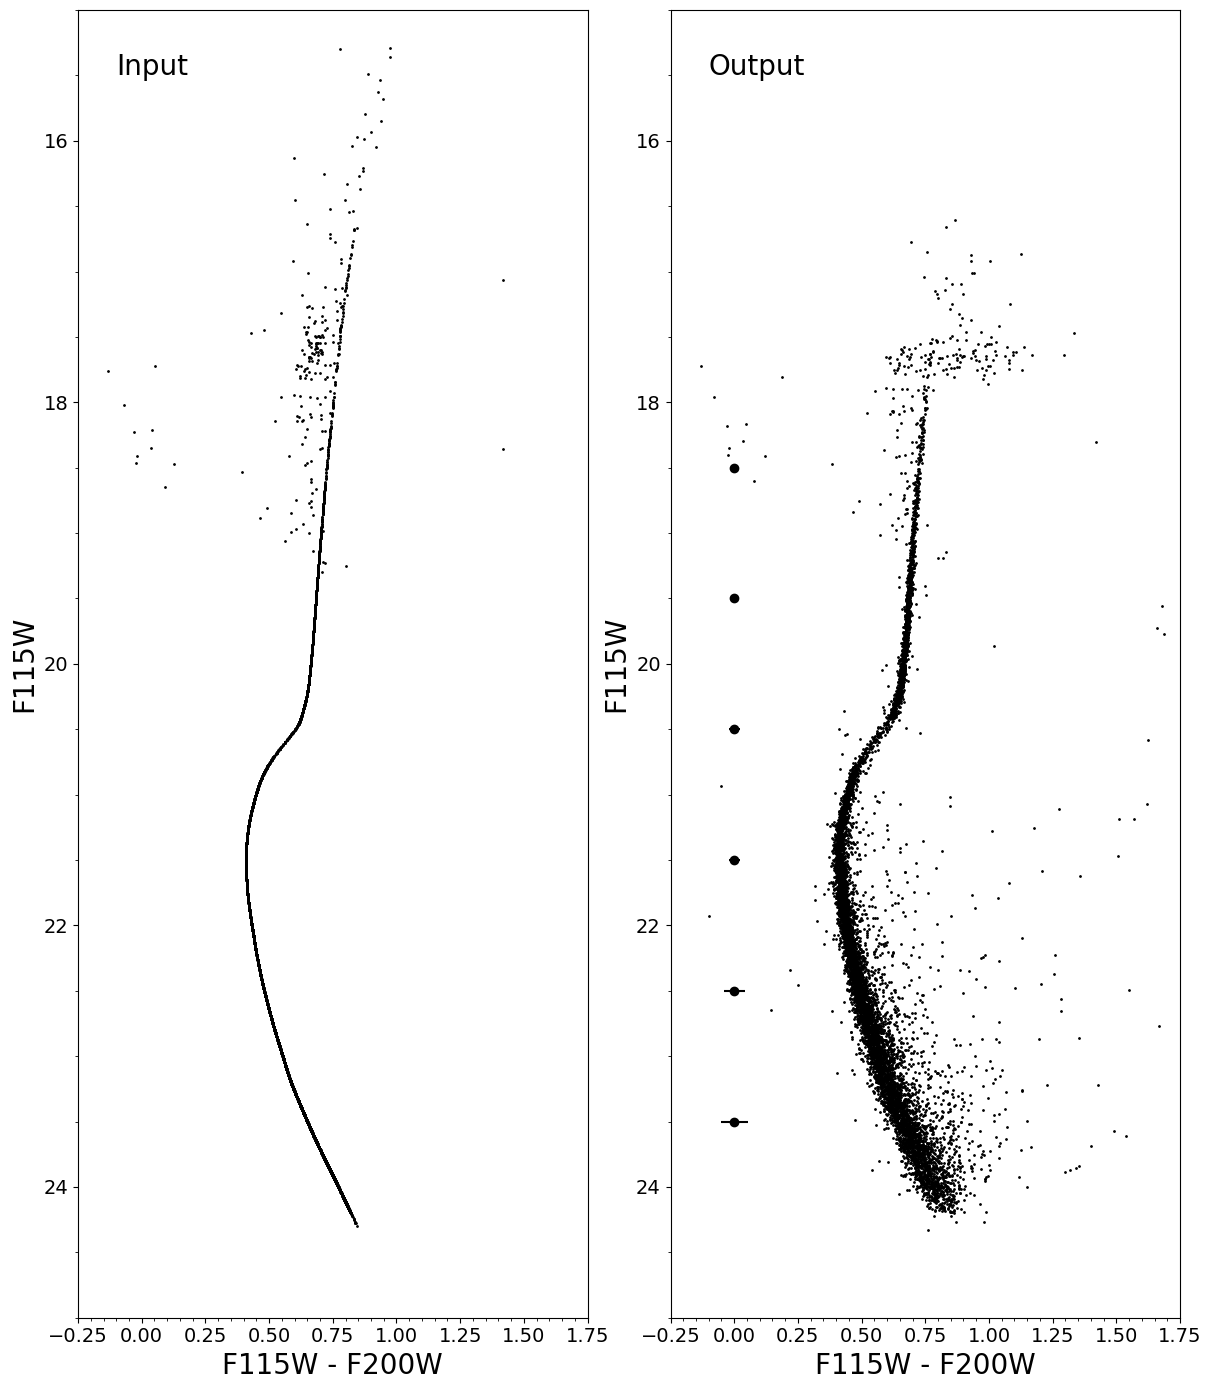

In [52]:
plt.figure(figsize=(12, 14))
plt.clf()

ax1 = plt.subplot(1, 2, 1)

mag1_in = np.array(cat_sel['f115w_in'])
mag2_in = np.array(cat_sel['f200w_in'])
diff_in = mag1_in - mag2_in

xlim0 = -0.25
xlim1 = 1.75
ylim0 = 25
ylim1 = 15 
ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(mag1_in - mag2_in, mag1_in, s=1, color='k')

ax1.set_xlabel(filt1 + ' - ' + filt2, fontdict=font2)
ax1.set_ylabel(filt1, fontdict=font2)
ax1.text(xlim0 + 0.15, 15.5, "Input", fontdict=font2)

ax2 = plt.subplot(1, 2, 2)

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

f115w = f115w_inst + zp_f115w 
f200w = f200w_inst + zp_f200w

maglim = np.arange(18, 25, 1)
mags = []
errs_mag = []
errs_col = []

for i in np.arange(0, len(maglim) - 1, 1):

    mag = (maglim[i] + maglim[i + 1]) / 2
    err_mag1 = ef115w_inst[(f115w > maglim[i]) & (f115w < maglim[i + 1])]
    err_mag2 = ef200w_inst[(f115w > maglim[i]) & (f115w < maglim[i + 1])]
    err_mag = np.mean(err_mag1[i])
    err_temp = np.sqrt(err_mag1**2 + err_mag2**2)
    err_col = np.mean(err_temp[i])

    errs_mag.append(err_mag)                  
    errs_col.append(err_col)
    mags.append(mag)

col = [0] * (len(maglim) - 1)

ax2.errorbar(col, mags, yerr=errs_mag, xerr=errs_col, fmt='o', color='k')
        
ax2.scatter(f115w - f200w, f115w, s=1, color='k')
ax2.text(xlim0 + 0.15, 15.5, "Output", fontdict=font2)

ax2.set_xlabel(filt1 + ' - ' + filt2, fontdict=font2)
ax2.set_ylabel(filt1, fontdict=font2)

plt.tight_layout()

## Comparison between input and output photometry 

2024-11-12 19:52:02,017 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,018 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,104 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,172 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,205 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,324 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,325 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,326 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,364 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,365 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


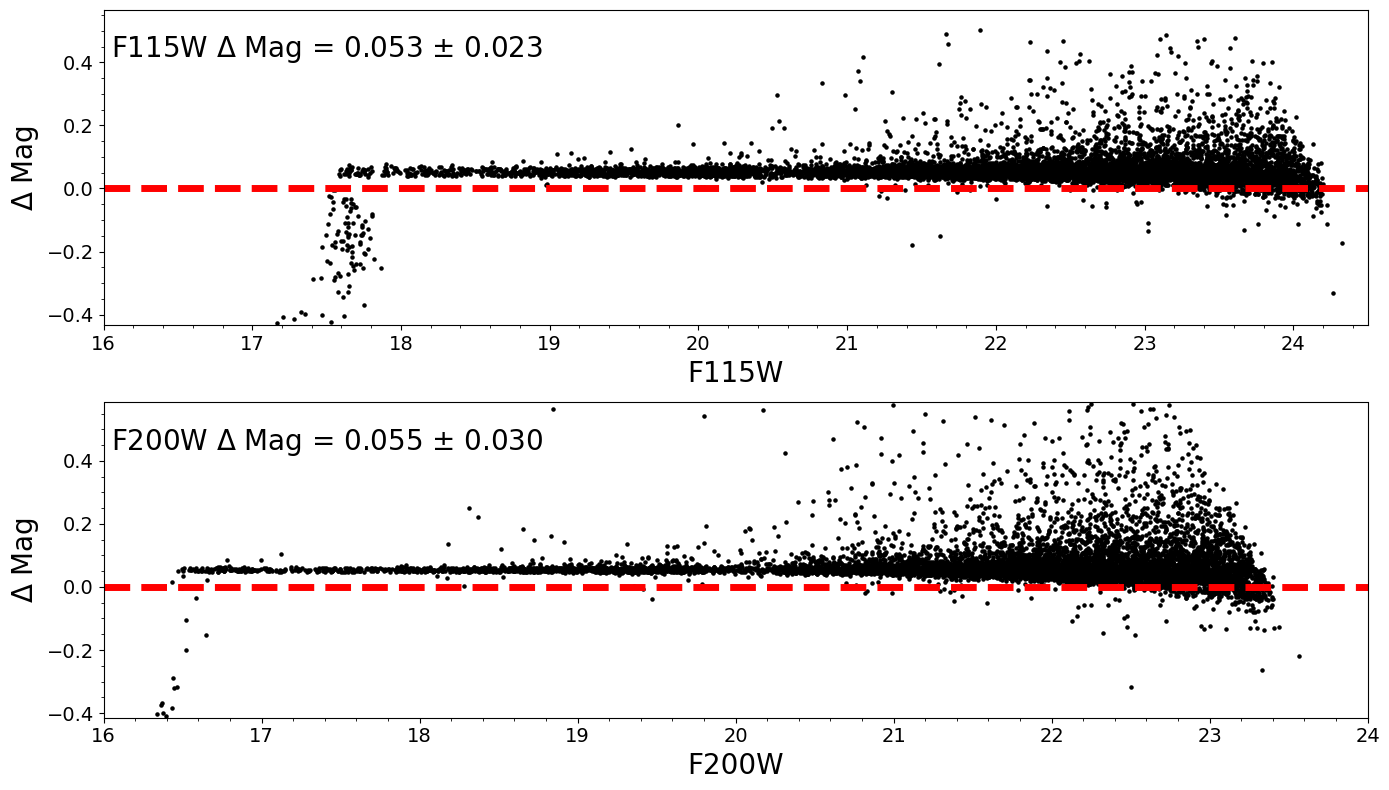

In [53]:
plt.figure(figsize=(14, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel(filt1, fontdict=font2)
ax1.set_ylabel(r'$\Delta$ Mag', fontdict=font2)

radec_input = SkyCoord(cat_sel['ra_in'], cat_sel['dec_in'], unit='deg')

idx_f115w_cfr, d2d_f115w_cfr, _ = match_coordinates_sky(radec_input, radec_f115w)

sep_f115w_cfr = d2d_f115w_cfr < max_sep

f115w_inp_cfr = np.array(cat_sel['f115w_in'][sep_f115w_cfr])
f115w_psf_cfr = np.array(f115w[idx_f115w_cfr[sep_f115w_cfr]])

diff_f115w_cfr = f115w_inp_cfr - f115w_psf_cfr
_, med_diff_f115w_cfr, sig_diff_f115w_cfr = sigma_clipped_stats(diff_f115w_cfr)

xlim0 = 16
xlim1 = 24.5
ylim0 = np.mean(diff_f115w_cfr) - 0.5
ylim1 = np.mean(diff_f115w_cfr) + 0.5

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(f115w_psf_cfr, diff_f115w_cfr, s=5, color='k')
ax1.plot([xlim0, xlim1], [0, 0], color='r', lw=5, ls='--')
text = rf'{filt1} $\Delta$ Mag = {med_diff_f115w_cfr:5.3f} $\pm$ {sig_diff_f115w_cfr:5.3f}'
ax1.text(xlim0 + 0.05, ylim1 - 0.15, text, color='k', fontdict=font2)

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel(filt2, fontdict=font2)
ax2.set_ylabel(r'$\Delta$ Mag', fontdict=font2)

idx_f200w_cfr, d2d_f200w_cfr, _ = match_coordinates_sky(radec_input, radec_f200w)

sep_f200w_cfr = d2d_f200w_cfr < max_sep

f200w_inp_cfr = np.array(cat_sel['f200w_in'][sep_f200w_cfr])
f200w_psf_cfr = np.array(f200w[idx_f200w_cfr[sep_f200w_cfr]])

diff_f200w_cfr = f200w_inp_cfr - f200w_psf_cfr
_, med_diff_f200w_cfr, sig_diff_f200w_cfr = sigma_clipped_stats(diff_f200w_cfr)

xlim0 = 16
xlim1 = 24
ylim0 = np.mean(diff_f200w_cfr) - 0.5 
ylim1 = np.mean(diff_f200w_cfr) + 0.5

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax2.scatter(f200w_psf_cfr, diff_f200w_cfr, s=5, color='k')
ax2.plot([xlim0, xlim1], [0, 0], color='r', lw=5, ls='--')

text = rf'{filt2} $\Delta$ Mag = {med_diff_f200w_cfr:5.3f} $\pm$ {sig_diff_f200w_cfr:5.3f}'

ax2.text(xlim0 + 0.05, ylim1 - 0.15, text, color='k', fontdict=font2)

plt.tight_layout()

2024-11-12 19:52:02,502 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,548 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,619 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,671 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,713 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,839 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,843 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,881 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,890 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


2024-11-12 19:52:02,926 - stpipe - WARNING - findfont: Font family 'helvetica' not found.


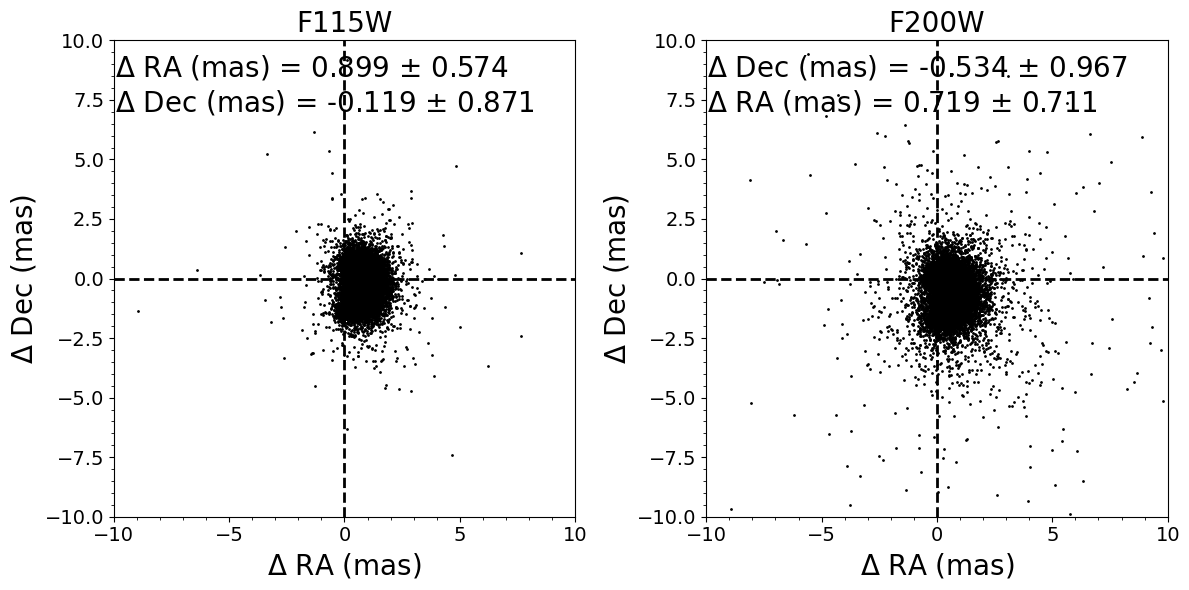

In [54]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)

xlim0 = -10
xlim1 = 10
ylim0 = -10
ylim1 = 10

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.set_xlabel(r'$\Delta$ RA (mas)', fontdict=font2)
ax1.set_ylabel(r'$\Delta$ Dec (mas)', fontdict=font2)
ax1.set_title(filt1, fontdict=font2)

ra_f115w_inp_cfr = np.array(cat_sel['ra_in'][sep_f115w_cfr])
ra_f115w_psf_cfr = np.array(radec_f115w.ra[idx_f115w_cfr[sep_f115w_cfr]])

dec_f115w_inp_cfr = np.array(cat_sel['dec_in'][sep_f115w_cfr])
dec_f115w_psf_cfr = np.array(radec_f115w.dec[idx_f115w_cfr[sep_f115w_cfr]])

dec_rad_f115w = np.radians(dec_f115w_psf_cfr)

diffra_f115w_cfr = ((((ra_f115w_inp_cfr - ra_f115w_psf_cfr) * np.cos(dec_rad_f115w)) * u.deg).to(u.mas) / (1 * u.mas))

_, med_diffra_f115w_cfr, sig_diffra_f115w_cfr = sigma_clipped_stats(diffra_f115w_cfr)

diffdec_f115w_cfr = (((dec_f115w_inp_cfr - dec_f115w_psf_cfr) * u.deg).to(u.mas) / (1 * u.mas))

_, med_diffdec_f115w_cfr, sig_diffdec_f115w_cfr = sigma_clipped_stats(diffdec_f115w_cfr)

ax1.scatter(diffra_f115w_cfr, diffdec_f115w_cfr, s=1, color='k')
ax1.plot([0, 0], [ylim0, ylim1], color='k', lw=2, ls='--')
ax1.plot([xlim0, xlim1], [0, 0], color='k', lw=2, ls='--')

text = rf'$\Delta$ RA (mas) = {med_diffra_f115w_cfr:5.3f} $\pm$ {sig_diffra_f115w_cfr:5.3f}'
ax1.text(xlim0 + 0.05, ylim1 - 1.50, text, color='k', fontdict=font2)

text = rf'$\Delta$ Dec (mas) = {med_diffdec_f115w_cfr:5.3f} $\pm$ {sig_diffdec_f115w_cfr:5.3f}'
ax1.text(xlim0 + 0.05, ylim1 - 3.0, text, color='k', fontdict=font2)

ax2 = plt.subplot(1, 2, 2)

xlim0 = -10
xlim1 = 10
ylim0 = -10
ylim1 = 10

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)
ax2.set_title(filt2, fontdict=font2)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax2.set_xlabel(r'$\Delta$ RA (mas)', fontdict=font2)
ax2.set_ylabel(r'$\Delta$ Dec (mas)', fontdict=font2)

ra_f200w_inp_cfr = np.array(cat_sel['ra_in'][sep_f200w_cfr])
ra_f200w_psf_cfr = np.array(radec_f200w.ra[idx_f200w_cfr[sep_f200w_cfr]])

dec_f200w_inp_cfr = np.array(cat_sel['dec_in'][sep_f200w_cfr])
dec_f200w_psf_cfr = np.array(radec_f200w.dec[idx_f200w_cfr[sep_f200w_cfr]])

dec_rad_f200w = np.radians(dec_f200w_psf_cfr)

diffra_f200w_cfr = ((((ra_f200w_inp_cfr - ra_f200w_psf_cfr) * np.cos(dec_rad_f200w)) * u.deg).to(u.mas) / (1 * u.mas))

_, med_diffra_f200w_cfr, sig_diffra_f200w_cfr = sigma_clipped_stats(diffra_f200w_cfr)

diffdec_f200w_cfr = (((dec_f200w_inp_cfr - dec_f200w_psf_cfr) * u.deg).to(u.mas) / (1 * u.mas))

_, med_diffdec_f200w_cfr, sig_diffdec_f200w_cfr = sigma_clipped_stats(diffdec_f200w_cfr)

ax2.scatter(diffra_f200w_cfr, diffdec_f200w_cfr, s=1, color='k')
ax2.plot([0, 0], [ylim0, ylim1], color='k', lw=2, ls='--')
ax2.plot([xlim0, xlim1], [0, 0], color='k', lw=2, ls='--')

text = rf'$\Delta$ Dec (mas) = {med_diffdec_f200w_cfr:5.3f} $\pm$ {sig_diffdec_f200w_cfr:5.3f}'
ax2.text(xlim0 + 0.05, ylim1 - 1.50, text, color='k', fontdict=font2)

text = rf'$\Delta$ RA (mas) = {med_diffra_f200w_cfr:5.3f} $\pm$ {sig_diffra_f200w_cfr:5.3f}'
ax2.text(xlim0 + 0.05, ylim1 - 3.0, text, color='k', fontdict=font2)

plt.tight_layout()

## Final notes

This notebook provides a general overview on how to perform PSF photometry using the [photutils](https://photutils.readthedocs.io/en/stable/) package. The choice of the different parameters adopted in all the reduction steps as well as the choice of the PSF model depend on the specific user science case. Moreover, a detailed analysis that allow to provide recommendations on how to set those parameters and outline the differences in the output photometry when different PSF models are adopted (single vs PSF grid, number of PSFs in the grid, etc.) will be possible only when real data will be available after the instrument commissioning. In this context, we note that one of the selected ERS program (ERS 1334 - The Resolved Stellar Populations Early Release Science Program) will provide a fundamental test benchmark to explore how the different choices outlined above will impact the quality of the PSF photometry in a crowded stellar region.

## About this Notebook

**Authors**: Matteo Correnti, JWST/NIRCam STScI Scientist II & Larry Bradley, Branch Deputy, Data Analysis Tools Branch\
**Updated on**: 2024-10-22

[Top of Page](#top)

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>